In [3]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: URLError <urlopen error timed out>


In [4]:
# b = phoebe.load("../estimations/bundle-saves/ebai-estimates-trimmed")
b = phoebe.load("../estimations/bundle-saves/comp-LID3/ebai-estimates-trimmed")
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

100%|██████████| 1414/1414 [03:43<00:00,  6.33it/s]


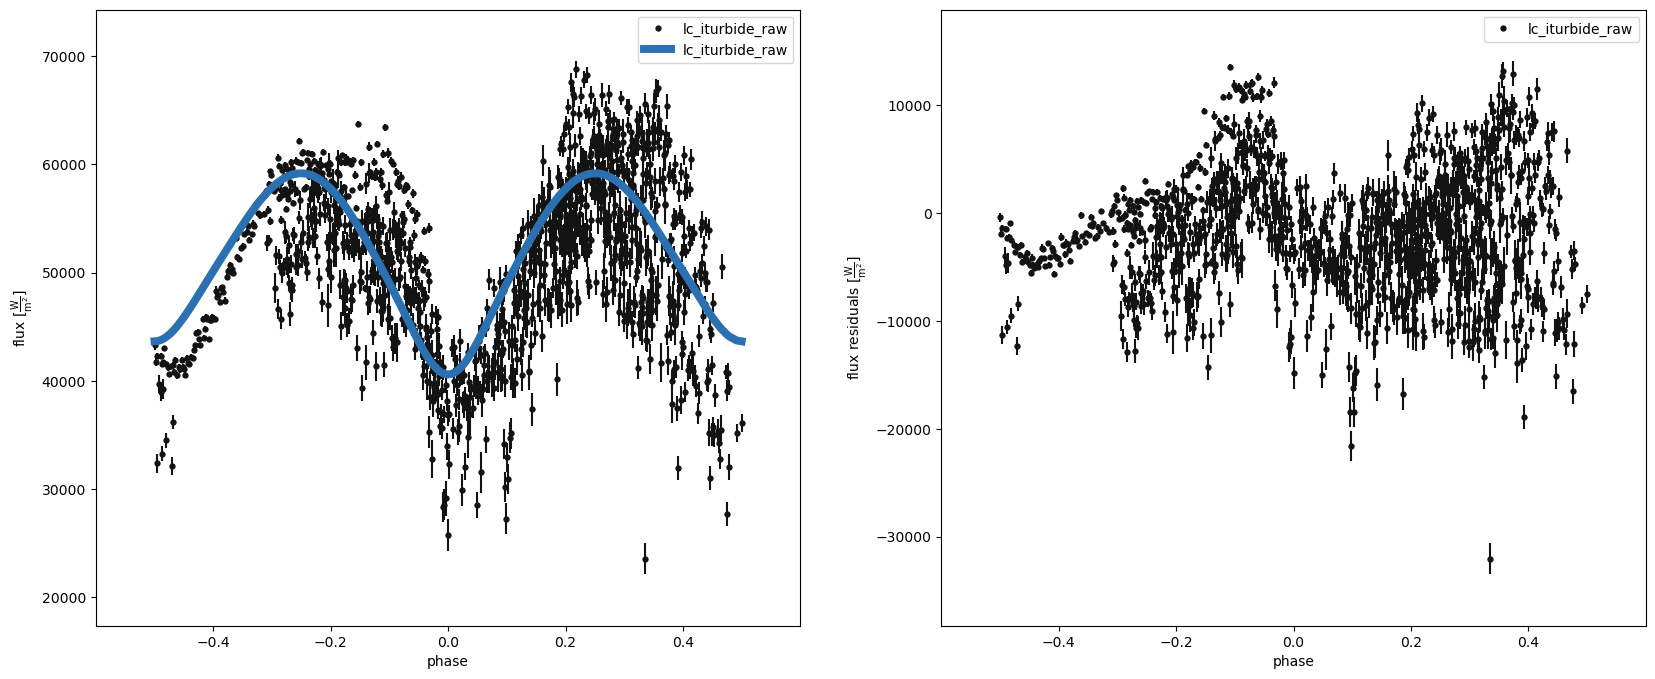

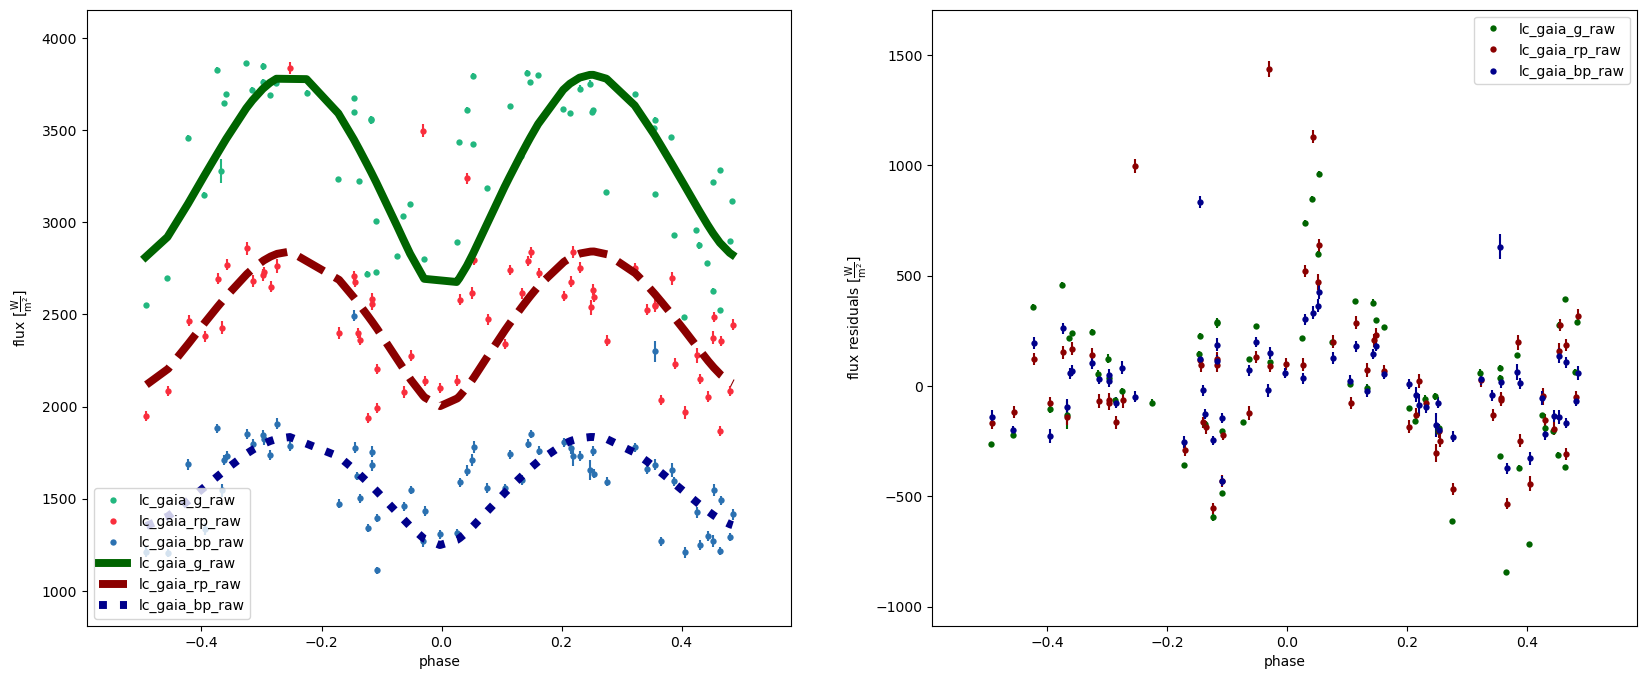

In [6]:
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers')

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model='before_optimizers', legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [5]:
def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	print('\t', "Iturbide -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	for gd in rawGaiaDatasets:
		print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))

In [7]:
printChi2(b, 'before_optimizers')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974


## Period and `t0_supconj`

In [8]:
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], label='period_t0', export=True, datasets=allRawDatasets, subfolder="differential-norm-estimates", maxiter=150)
# opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], 'period_t0', False, allRawDatasets, maxiter=100)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_period_t0.py ./results/opt_period_t0_solution


('opt_period_t0', 'opt_period_t0_solution')

Adopted:
t0_supconj@binary@orbit@component = 0.15270 d
period@binary@orbit@component = 0.33358 d

Original values:
  t0_supconj@binary@orbit@component 0.14900860708333175 d
  period@binary@orbit@component 0.3335826898128127 d


Fri, 22 Sep 2023 12:31 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1398/1398 [03:31<00:00,  6.62it/s]


opt_period_t0_solution opt_period_t0_model


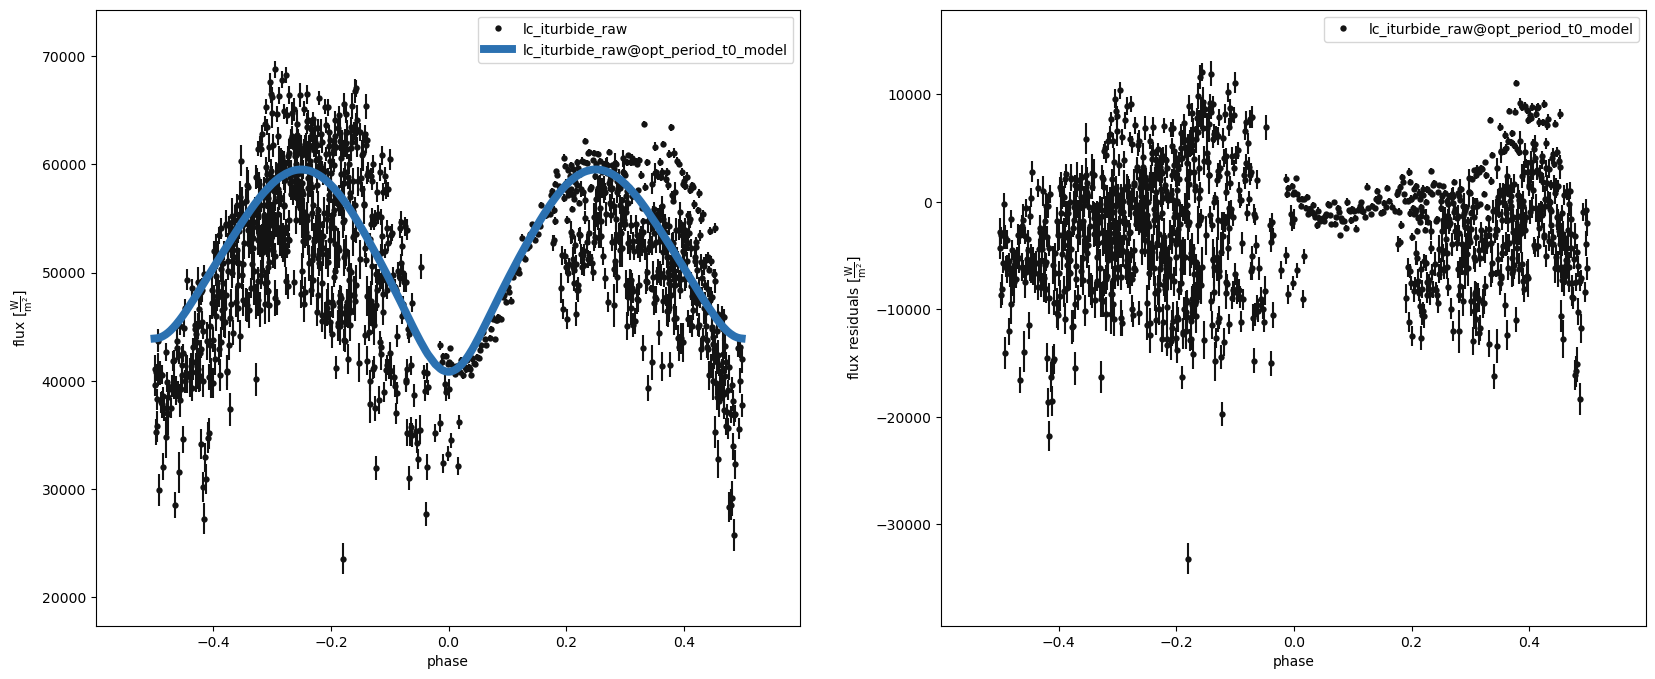

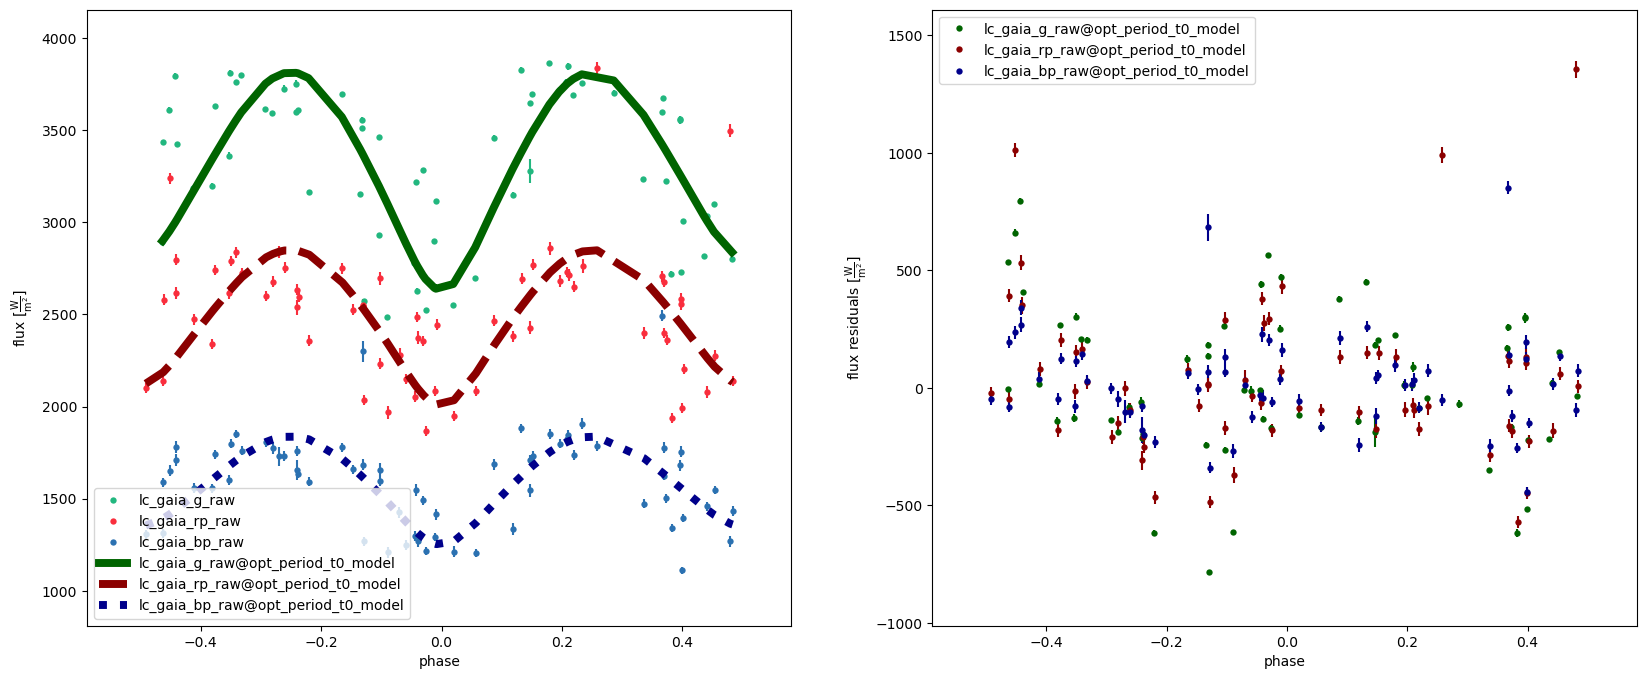

In [6]:
# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
#                                                           solution_file="./external-jobs/results/opt_period_t0_solution", plot=False, 
#                                                           dataset=allRawDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, plot=False, dataset=allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./external-jobs/differential-norm-estimates/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets)
print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [7]:
printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013


### Using Gaia datasets only

Seems like `t0_supconj` might not have been adjusted properly from Iturbide LC

In [17]:
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], 'period_t0_gaia', True, rawGaiaDatasets, maxiter=200)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_period_t0_gaia.py ./results/opt_period_t0_gaia_solution


('opt_period_t0_gaia', 'opt_period_t0_gaia_solution')

t0_supconj@binary@orbit@component = 0.09631 d
period@binary@orbit@component = 0.33330 d
Adopted
  t0_supconj@binary@orbit@component 0.09152173700368677 d
  period@binary@orbit@component 0.33330212084741745 d


100%|██████████| 1398/1398 [03:38<00:00,  6.40it/s]


opt_period_t0_gaia_solution opt_period_t0_gaia_model


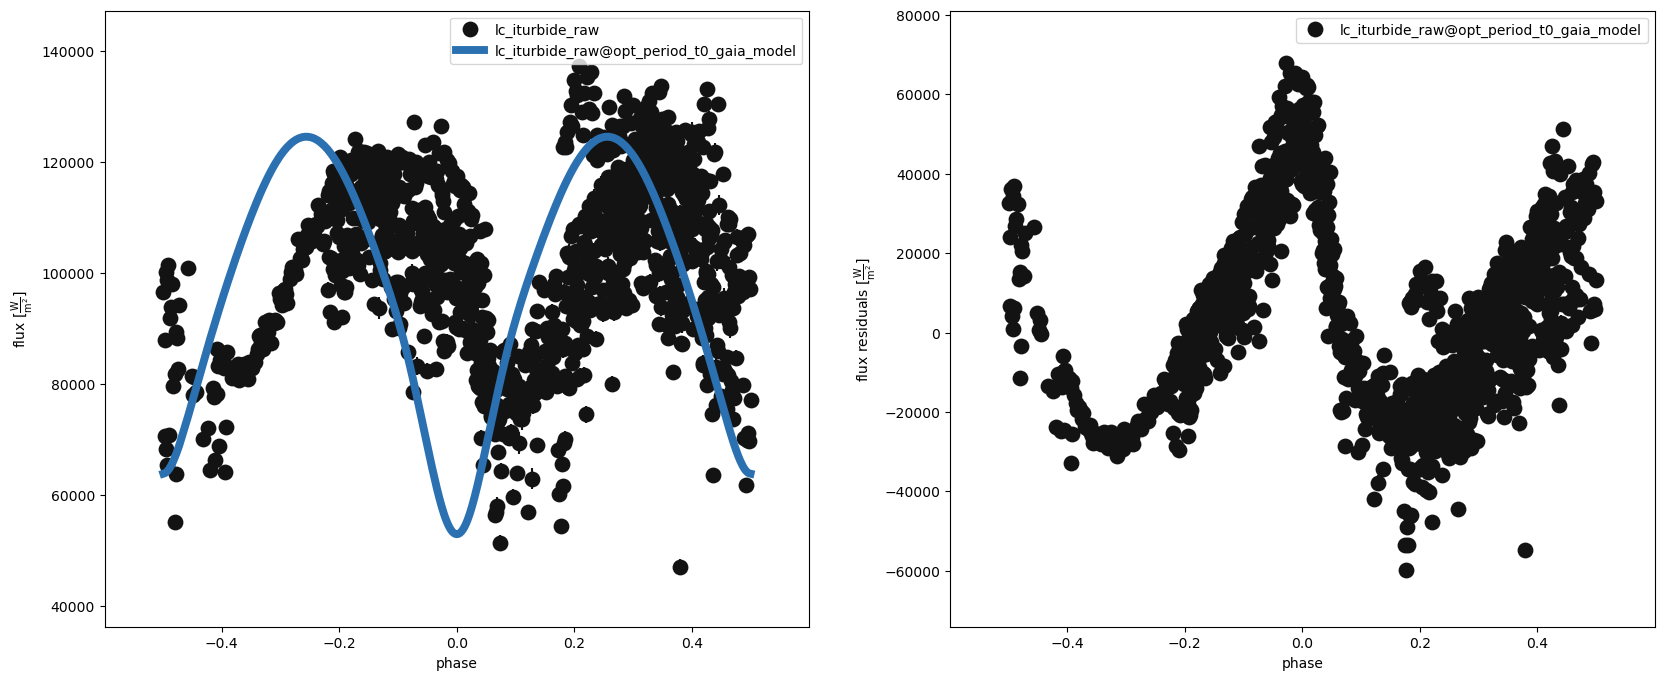

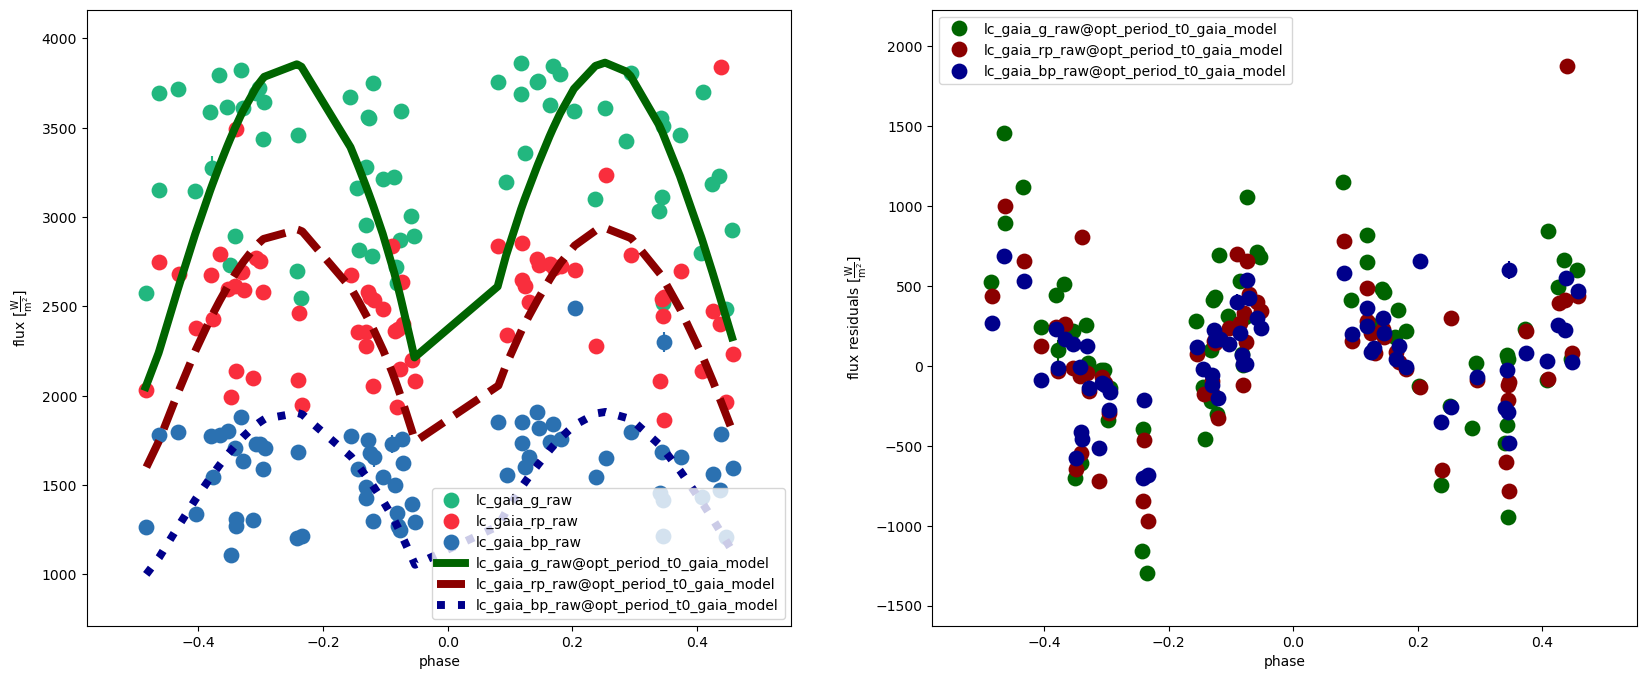

In [9]:
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, 
                                                          solution_file="./external-jobs/results/opt_period_t0_gaia_solution", plot=False, 
                                                          dataset=allRawDatasets)
print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [27]:
print(b['opt_period_t0_gaia_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@opt_period_t0_...: ['t0_supconj@binary@orbit@component' 'period@binary@orbit@component']
   adopt_parameters@opt_period...: ['t0_supconj@binary@orbit@component', 'period@binary@orbit@component']
   adopt_distributions@opt_per...: False
   adopt_values@opt_period_t0_...: True
R  message@opt_period_t0_gaia@...: Optimization terminated successfully.
R  niter@opt_period_t0_gaia@op...: 63
R  success@opt_period_t0_gaia@...: True
R  initial_values@opt_period_t...: [0.09152173700368677 0.33330212084741745]
R  fitted_values@opt_period_t0...: [0.09631321261339112 0.33329601845912604]
R  fitted_units@opt_period_t0_...: ['d' 'd']
   comments@opt_period_t0_gaia...: 


In [10]:
for m in b.models:
	printChi2(b, m)

before_optimizers
-------------------------------------
	 Iturbide - 1244789.9869257982
	 Gaia - 584040.2179725979
		 lc_gaia_g_raw - 510548.2300158256
		 lc_gaia_rp_raw - 44392.188906850104
		 lc_gaia_bp_raw - 29099.79904992223
opt_period_t0_model
-------------------------------------
	 Iturbide - 497243.39609177766
	 Gaia - 242222.2329210236
		 lc_gaia_g_raw - 208749.42571898212
		 lc_gaia_rp_raw - 20702.319609771515
		 lc_gaia_bp_raw - 12770.487592269945
opt_period_t0_gaia_model
-------------------------------------
	 Iturbide - 2317608.873023375
	 Gaia - 196326.47508051147
		 lc_gaia_g_raw - 169670.57299622413
		 lc_gaia_rp_raw - 16363.08685704666
		 lc_gaia_bp_raw - 10292.815227240679


#### Gaia individual datasets only (`t0_supconj` only)

In [11]:
for gd in rawGaiaDatasets:
	datasetLabel = gd.replace("lc_", "").replace("_raw", "")
	opt_utils.optimize_params(b, ['t0_supconj'], f't0_{datasetLabel}', False, [gd], maxiter=200)

 10%|█         | 20/200 [07:07<1:04:05, 21.36s/it]


In [12]:
gen_utils.saveBundle(b, "individual-gaia-estimates", "ebai-optimizers")

'bundle-saves/ebai-optimizers/individual-gaia-estimates'

t0_gaia_g
-----------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09610 d

Original values:
  t0_supconj@binary@orbit@component 0.09809062977464766 d


100%|██████████| 1414/1414 [03:40<00:00,  6.42it/s]


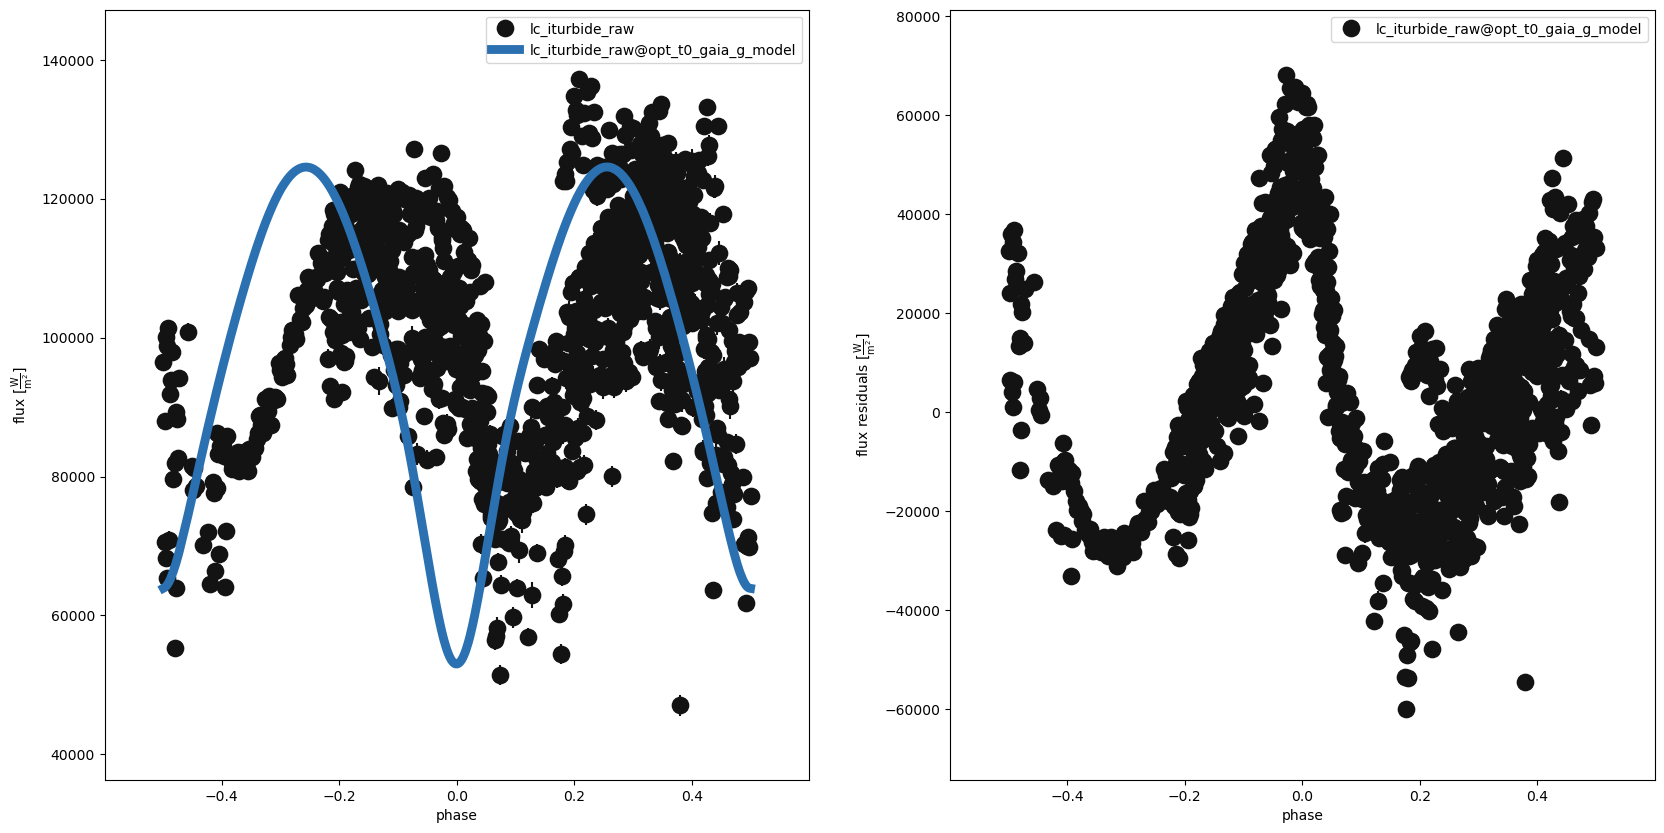

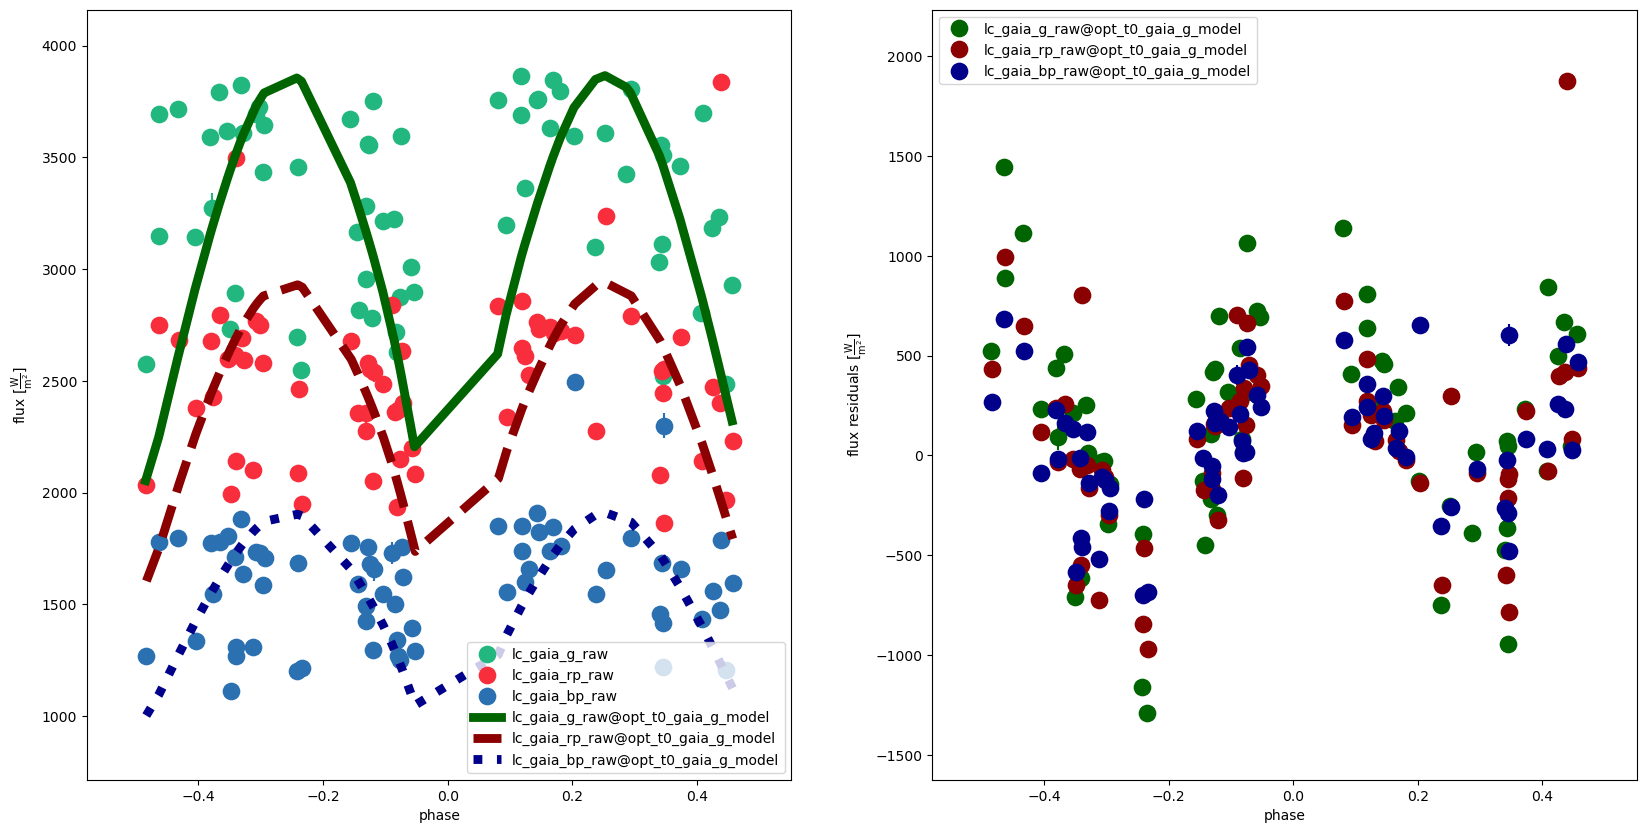


t0_gaia_rp
-----------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09809 d

Original values:
  t0_supconj@binary@orbit@component 0.09631321261339112 d


100%|██████████| 1414/1414 [03:36<00:00,  6.53it/s]


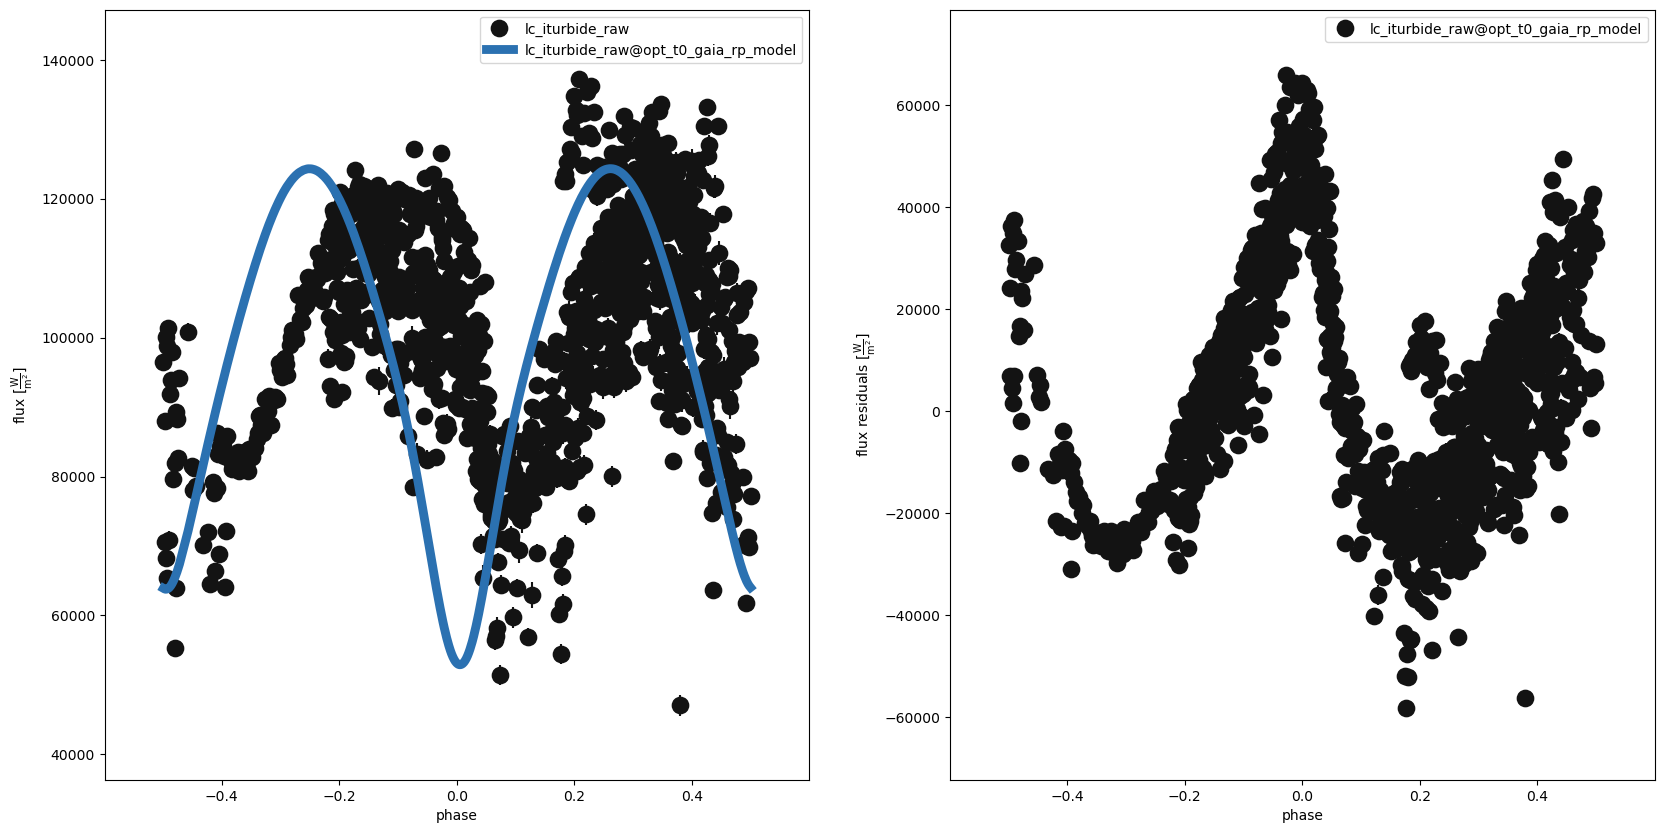

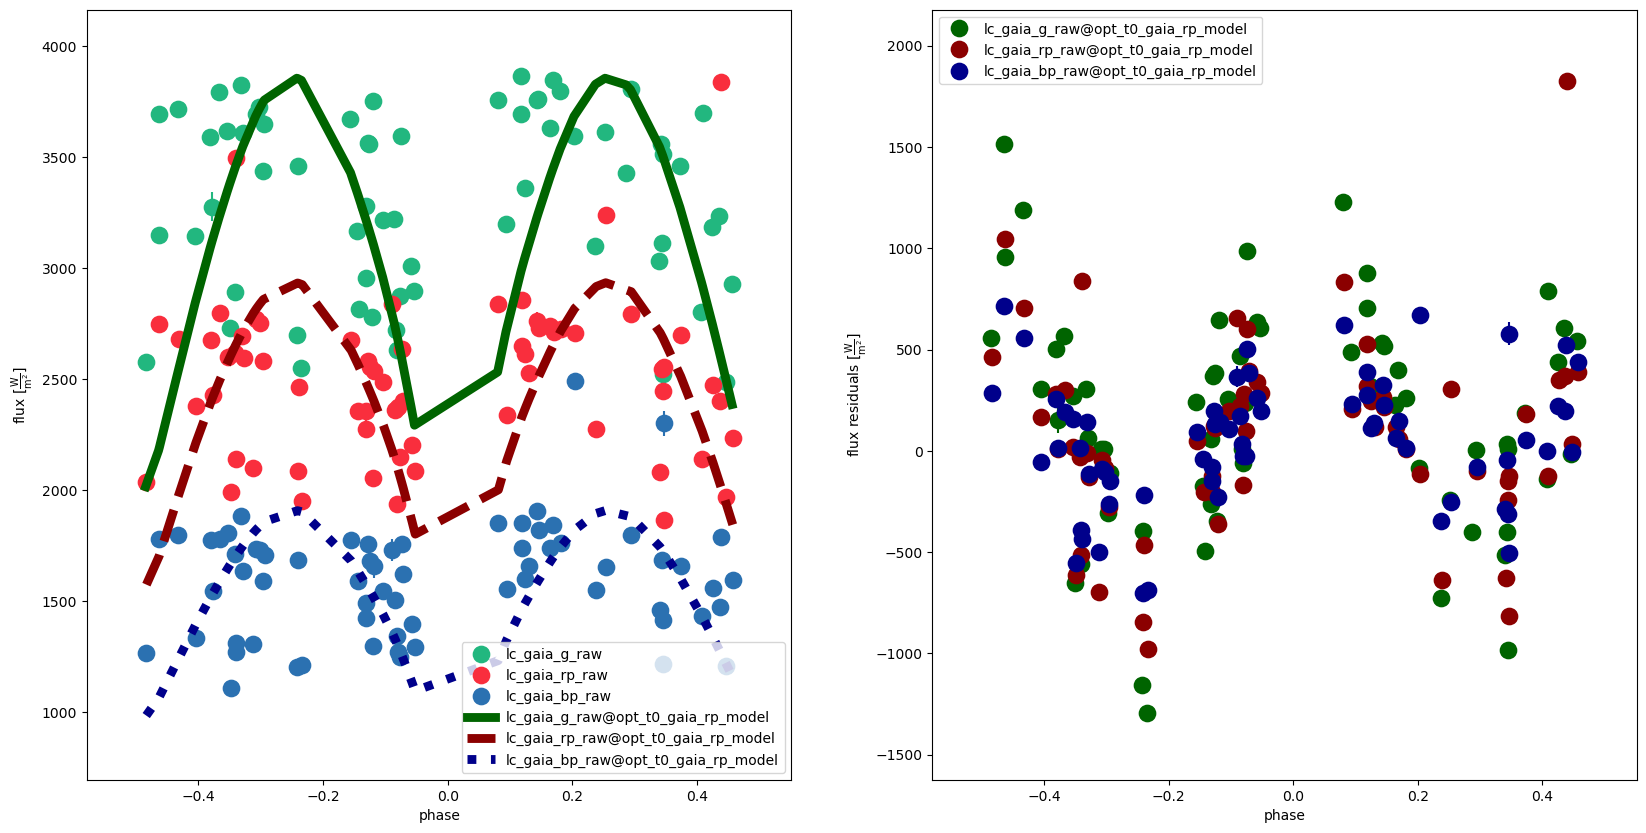


t0_gaia_bp
-----------------------------------------------
Adopted:
t0_supconj@binary@orbit@component = 0.09808 d

Original values:
  t0_supconj@binary@orbit@component 0.09631321261339112 d


100%|██████████| 1414/1414 [03:31<00:00,  6.69it/s]


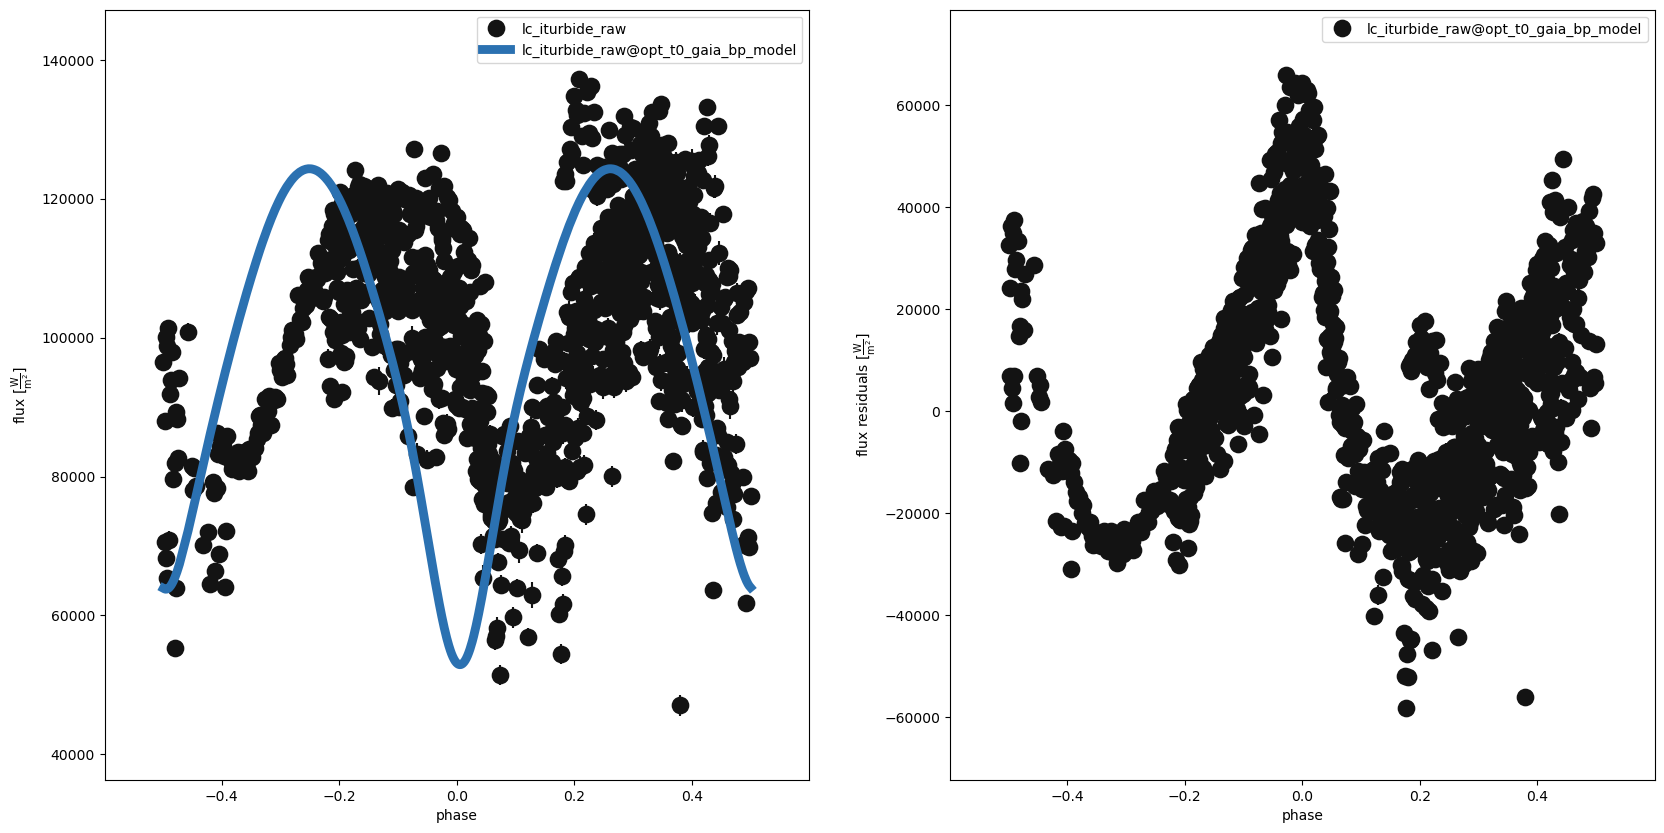

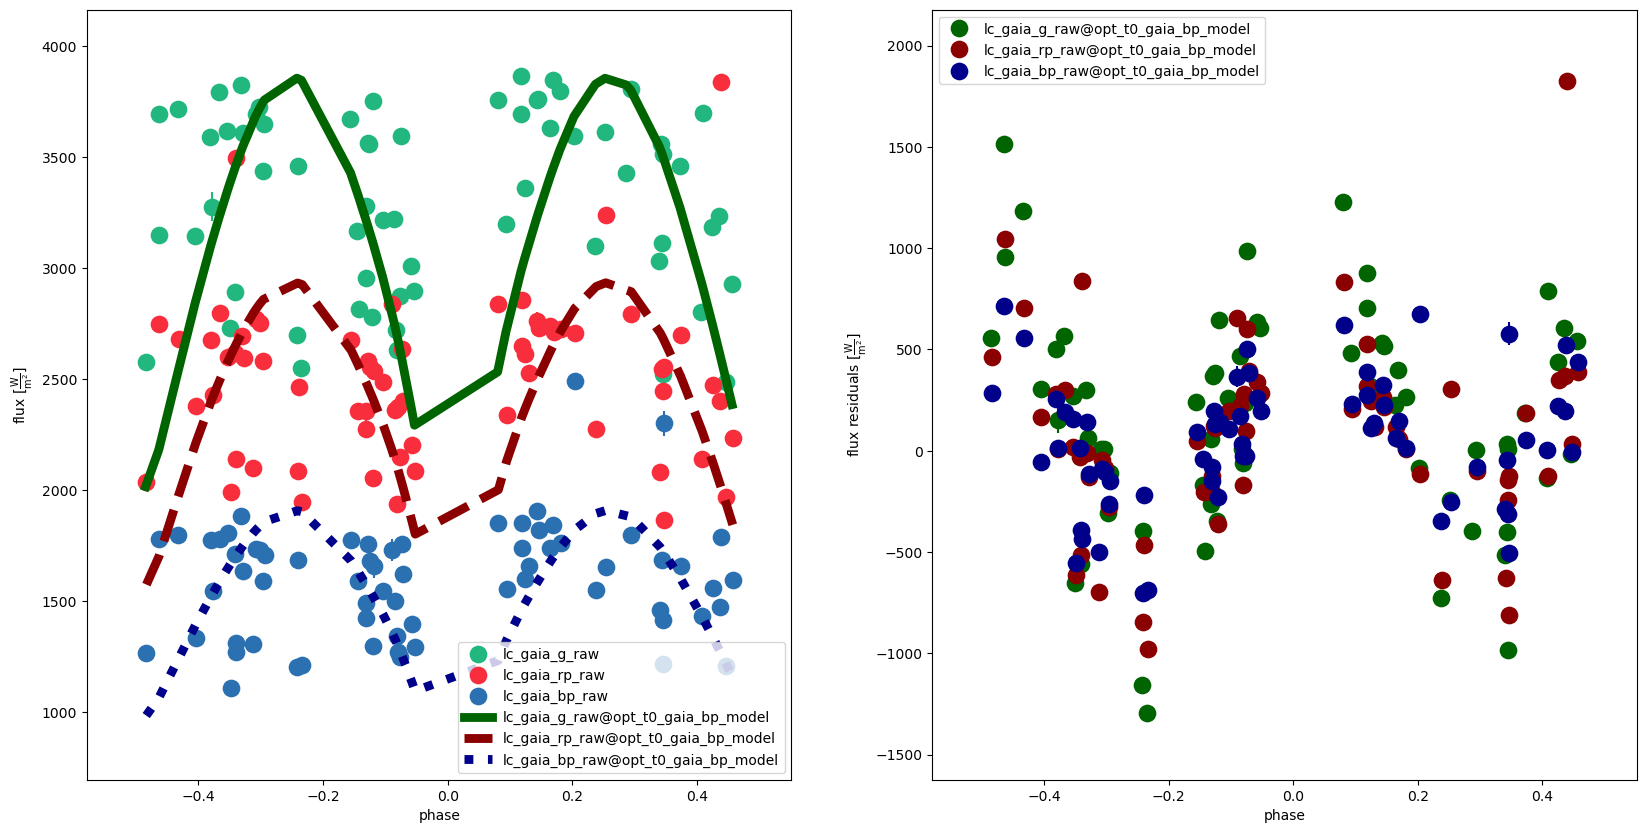

In [20]:
for gd in rawGaiaDatasets:
	label = f't0_{gd.replace("lc_", "").replace("_raw", "")}'
	print(label, "-----------------------------------------------", sep='\n')
	solutionName, computeModelName = opt_utils.adopt_solution(b, label=label, reset_params=True, run_compute=True, plot=False)
	gen_utils.plotModelResidualsFigsize(b, figsize=(20,8), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)
	print()

### Using Iturbide LC only

In [35]:
opt_utils.optimize_params(b, ['t0_supconj'], 't0_iturbide', True, ['lc_iturbide_raw'], maxiter=200)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_t0_iturbide.py ./results/opt_t0_iturbide_solution


('opt_t0_iturbide', 'opt_t0_iturbide_solution')

Adopted:
t0_supconj@binary@orbit@component = 0.13208 d

Original values:
  t0_supconj@binary@orbit@component 0.09631321261339112 d


100%|██████████| 1398/1398 [03:43<00:00,  6.26it/s]


opt_t0_iturbide_solution opt_t0_iturbide_model


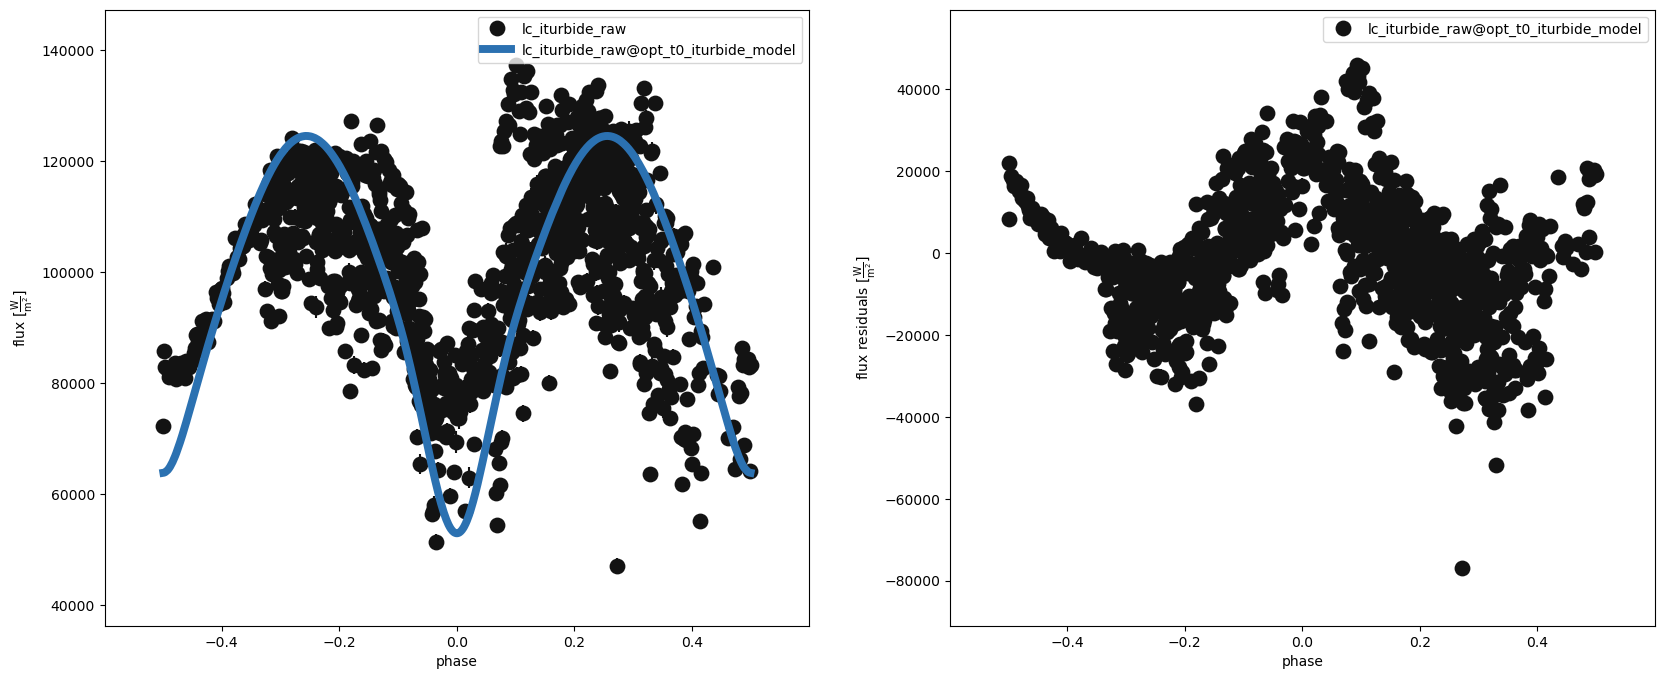

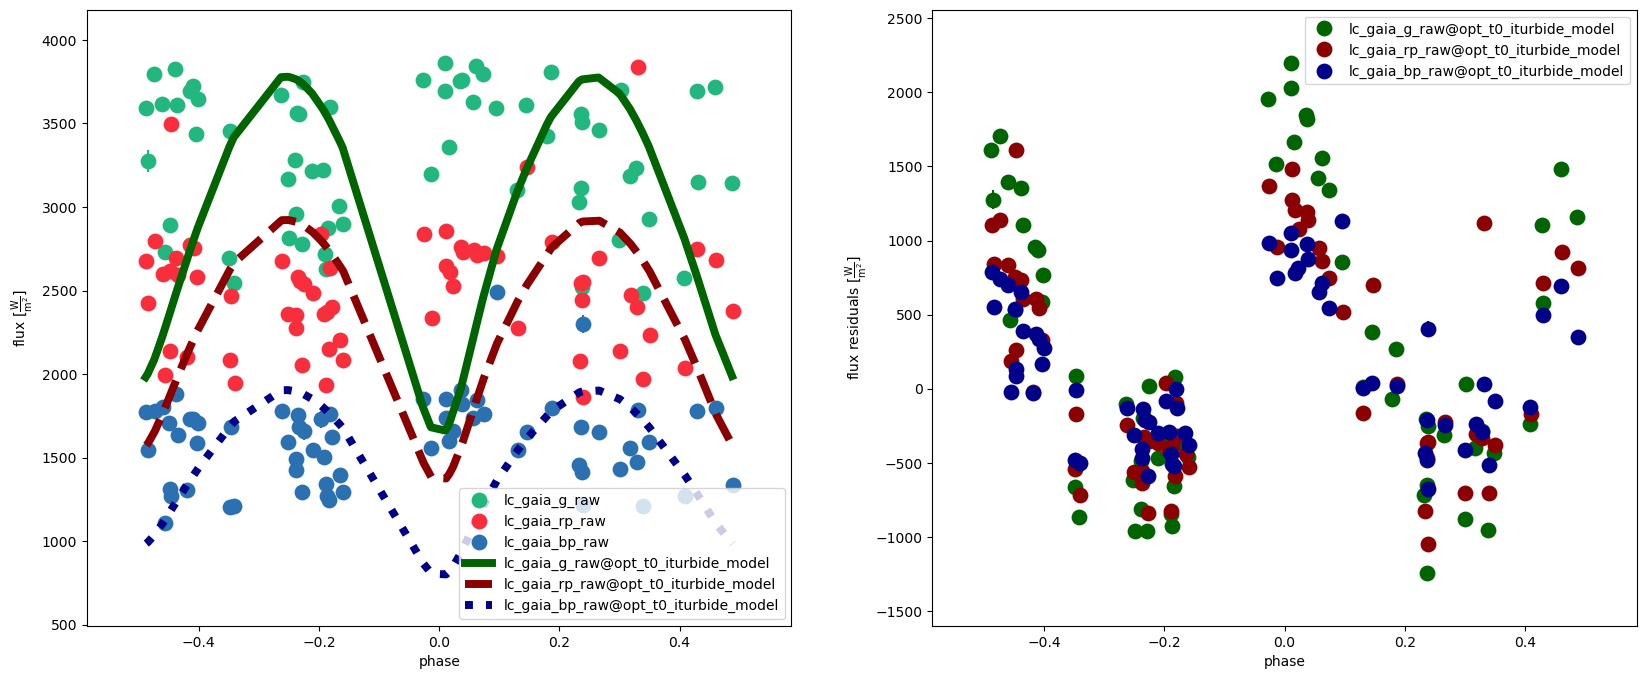

ParameterSet: 11 parameters
R  fitted_twigs@opt_t0_iturbid...: ['t0_supconj@binary@orbit@component']
   adopt_parameters@opt_t0_itu...: ['t0_supconj@binary@orbit@component']
   adopt_distributions@opt_t0_...: False
   adopt_values@opt_t0_iturbid...: True
R  message@opt_t0_iturbide@opt...: Optimization terminated successfully.
R  niter@opt_t0_iturbide@opt_t...: 32
R  success@opt_t0_iturbide@opt...: True
R  initial_values@opt_t0_iturb...: [0.09631321261339112]
R  fitted_values@opt_t0_iturbi...: [0.13207723908706887]
R  fitted_units@opt_t0_iturbid...: ['d']
   comments@opt_t0_iturbide@op...: 
opt_t0_iturbide_model
-------------------------------------
	 Iturbide - 496709.5434402015
	 Gaia - 568058.2354049268
		 lc_gaia_g_raw - 504338.7871925711
		 lc_gaia_rp_raw - 39080.62725851997
		 lc_gaia_bp_raw - 24638.82095383569


In [21]:
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, 
                                                          solution_file="./external-jobs/results/opt_t0_iturbide_solution", plot=False, 
                                                          dataset=allRawDatasets)
print(solutionName, computeModelName)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

print(b[solutionName])
print("==================================================")
printChi2(b, computeModelName)

### Using `t0_supconj` and `period` determined from Aviles' data

100%|██████████| 1414/1414 [03:36<00:00,  6.54it/s]


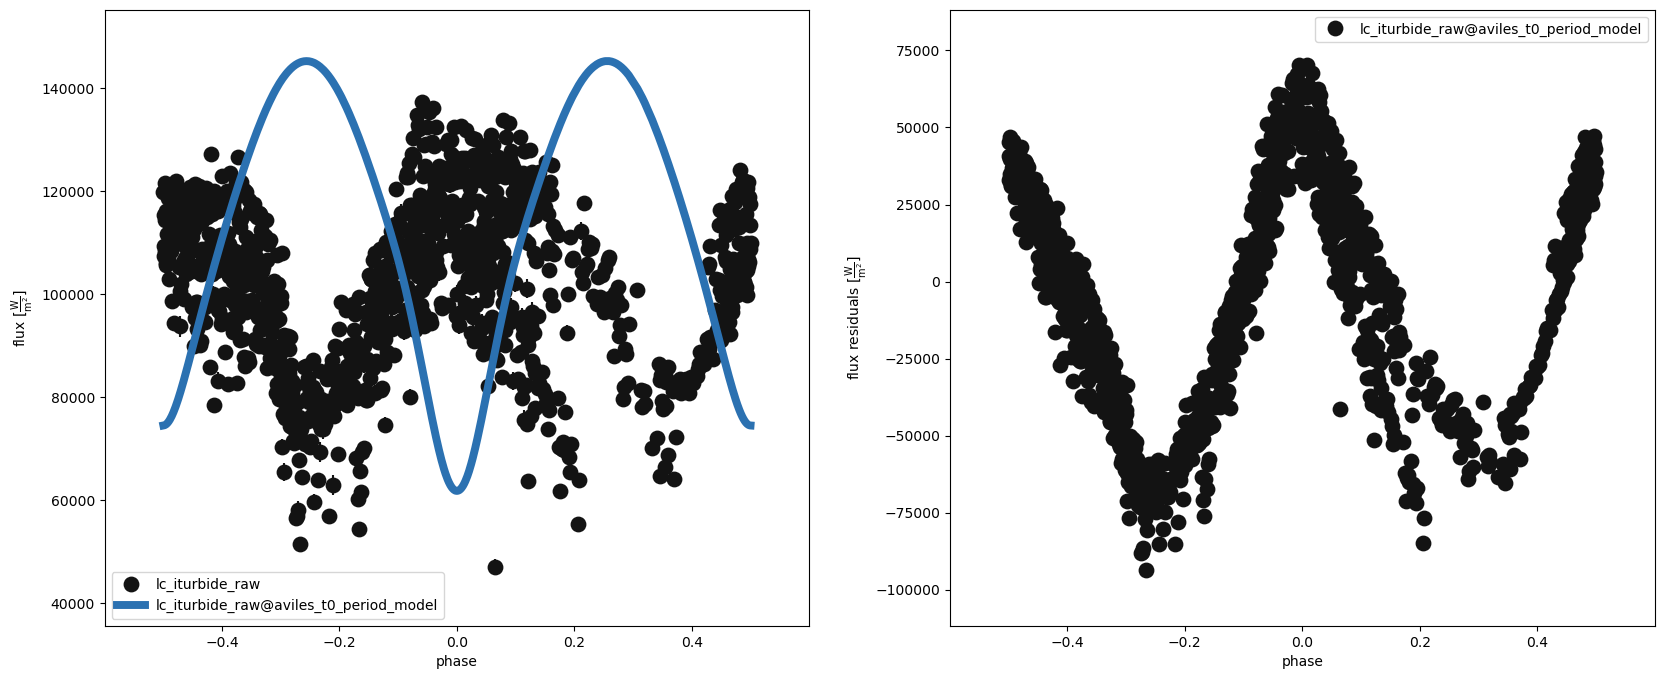

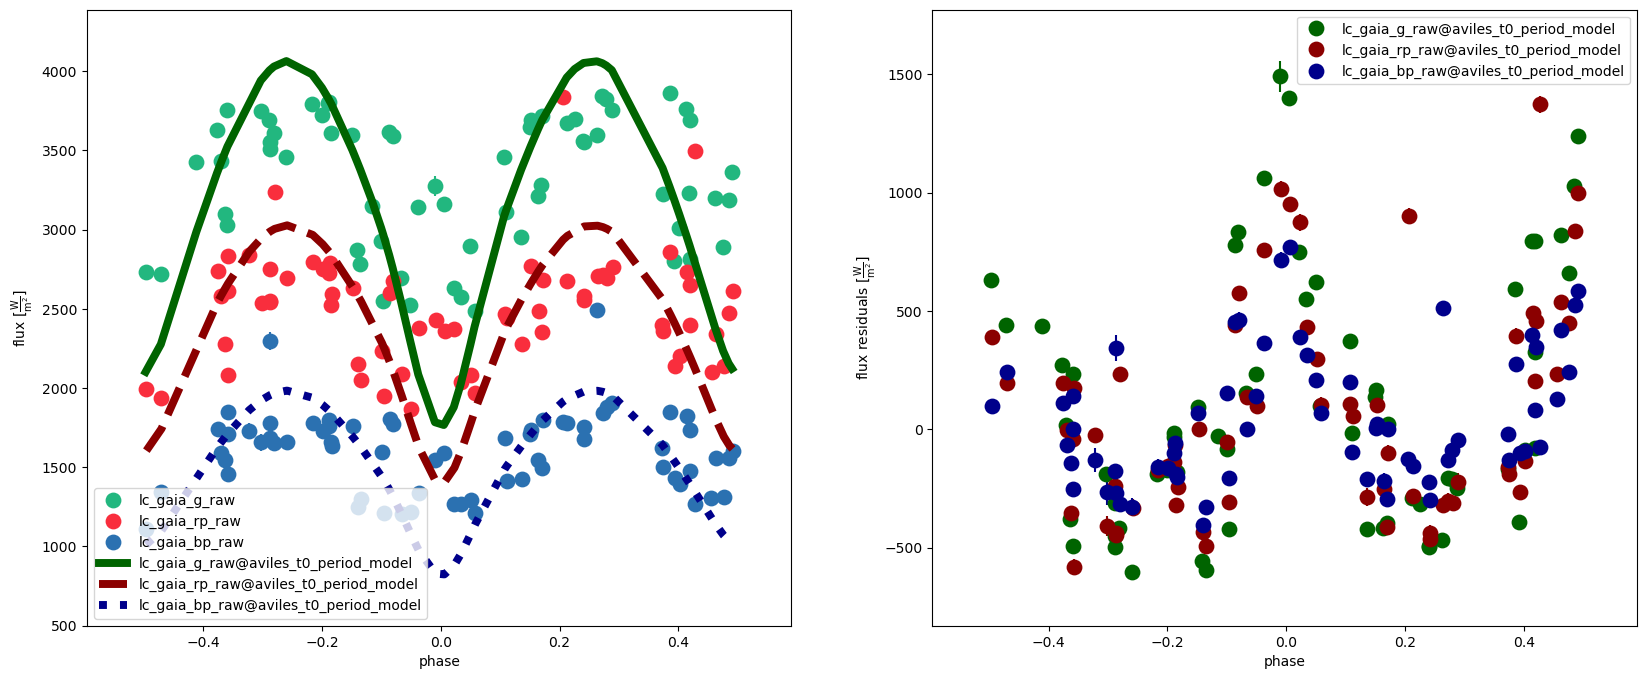

In [22]:
# ParameterSet: 11 parameters
# R  fitted_twigs@opt_period_t0@...: ['t0_supconj@binary@orbit@component' 'period@binary@orbit@component']
#    adopt_parameters@opt_period...: ['t0_supconj@binary@orbit@component', 'period@binary@orbit@component']
#    adopt_distributions@opt_per...: False
#    adopt_values@opt_period_t0@...: True
# R  message@opt_period_t0@opt_p...: Maximum number of iterations has been exceeded.
# R  niter@opt_period_t0@opt_per...: 150
# R  success@opt_period_t0@opt_p...: False
# R  initial_values@opt_period_t...: [0.07183033865425345 0.3335413828053897]
# R  fitted_values@opt_period_t0...: [0.07183187311538936 0.33354138280951534]
# R  fitted_units@opt_period_t0@...: ['d' 'd']
#    comments@opt_period_t0@opt_...: 

b.set_value(qualifier='t0_supconj', component='binary', value=0.07183187311538936*u.day)
b.set_value(qualifier='period', component='binary', value=0.33354138280951534*u.day)

b.run_compute(model='aviles_t0_period_model')
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model='aviles_t0_period_model', legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

## Width and depth of eclipses

`teffratio`, `fillout_factor`
* Testing out `fillout_factor` for parametrization of the shapes of the stars instead of manipulating their equivalent radii

In [8]:
backup = b.copy()

In [44]:
b = backup.copy()

In [46]:
print(b['requiv'])
print(b['requivsumfrac'])
print(b['requivratio'])
print(b['teffratio'])
print(b['mass'])
print(b['sma@binary'])
print(b['pot'])
print(b['fillout_factor'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.0337700401734613 solRad
C      requiv@secondary@component: 1.7436624098728664 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C  requivsumfrac@binary@component: 0.8290843134466649
         requivsumfrac@constraint: ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component}
ParameterSet: 2 parameters
C    requivratio@binary@component: 1.686702401996762
           requivratio@constraint: {requiv@secondary@component} / {requiv@primary@component}
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                          

### `lc_gaia_g` only

In [14]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_gaiag', subfolder="differential-norm-estimates",
						  export=True, datasets=['lc_gaia_g_raw'], maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_gaiag.py ./results/opt_teffratio_ff_gaiag_solution


('opt_teffratio_ff_gaiag', 'opt_teffratio_ff_gaiag_solution')

Adopted:
teffratio@binary@orbit@component = 0.93269 
fillout_factor@contact_envelope@envelope@component = 0.04415 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Fri, 22 Sep 2023 12:35 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [04:15<00:00,  5.52it/s]


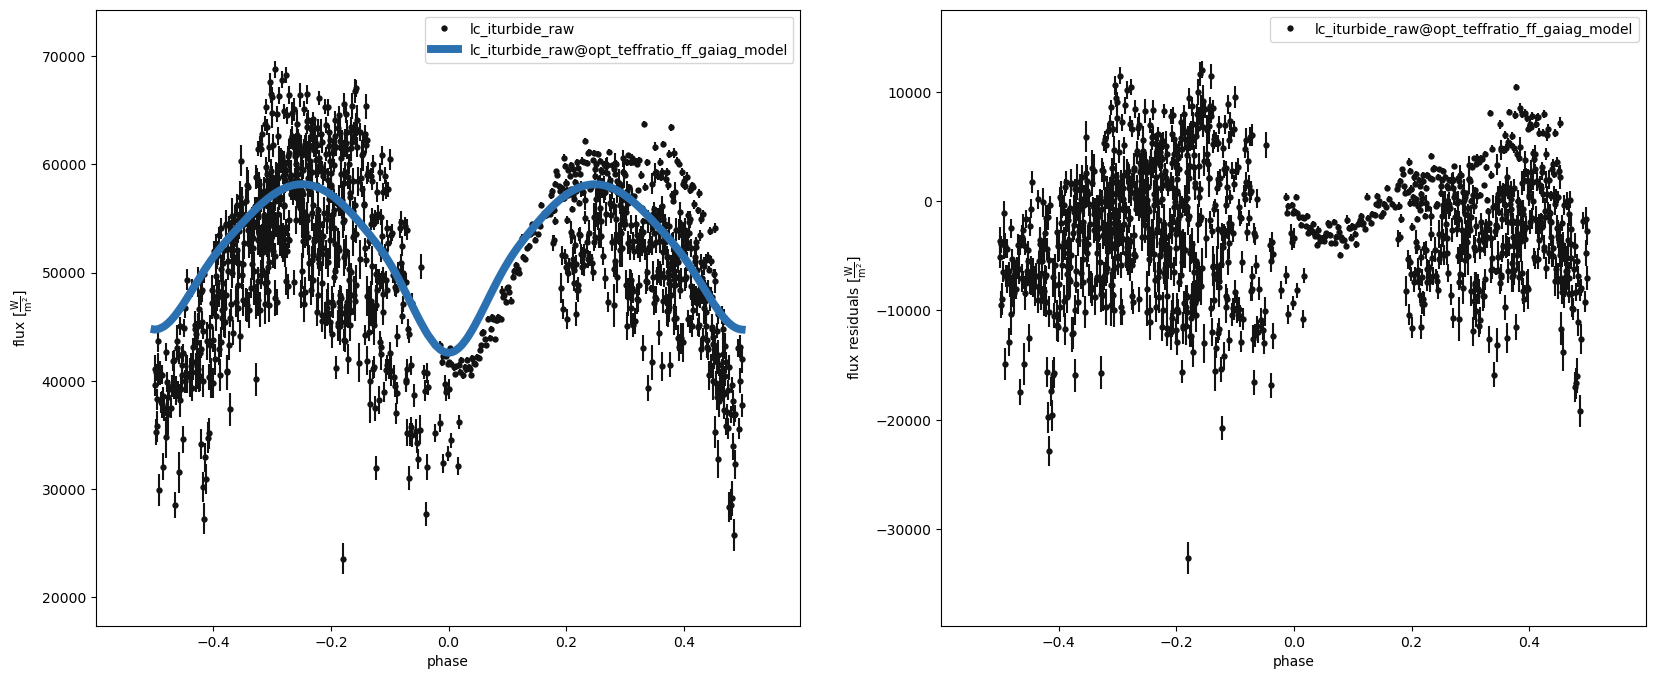

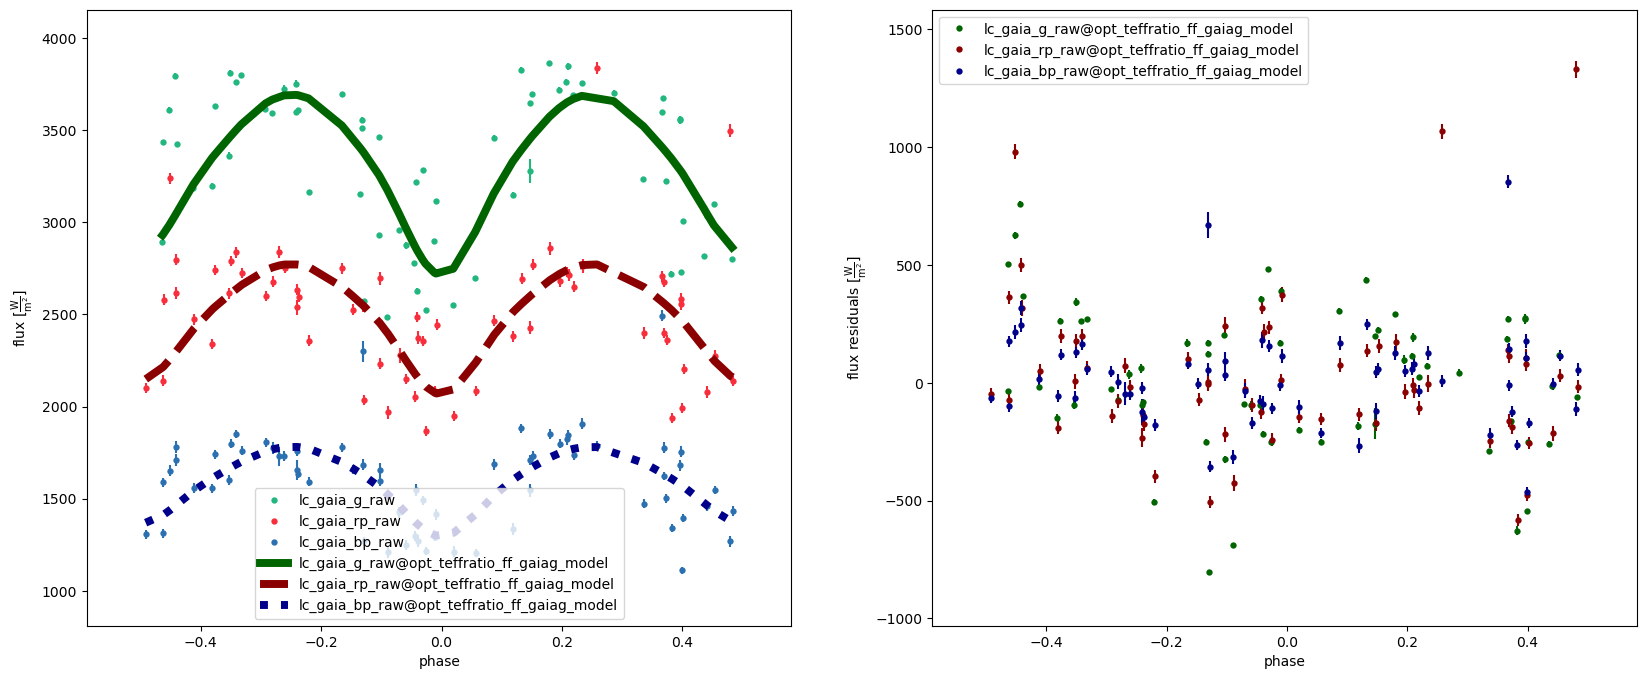

In [9]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_gaiag_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [10]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532


### `lc_iturbide` only

In [16]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_iturbide', subfolder="differential-norm-estimates",
						  export=True, datasets=['lc_iturbide_raw'], maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_iturbide.py ./results/opt_teffratio_ff_iturbide_solution


('opt_teffratio_ff_iturbide', 'opt_teffratio_ff_iturbide_solution')

Adopted:
teffratio@binary@orbit@component = 0.85438 
fillout_factor@contact_envelope@envelope@component = 0.29482 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Fri, 22 Sep 2023 12:39 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:27<00:00,  6.83it/s]


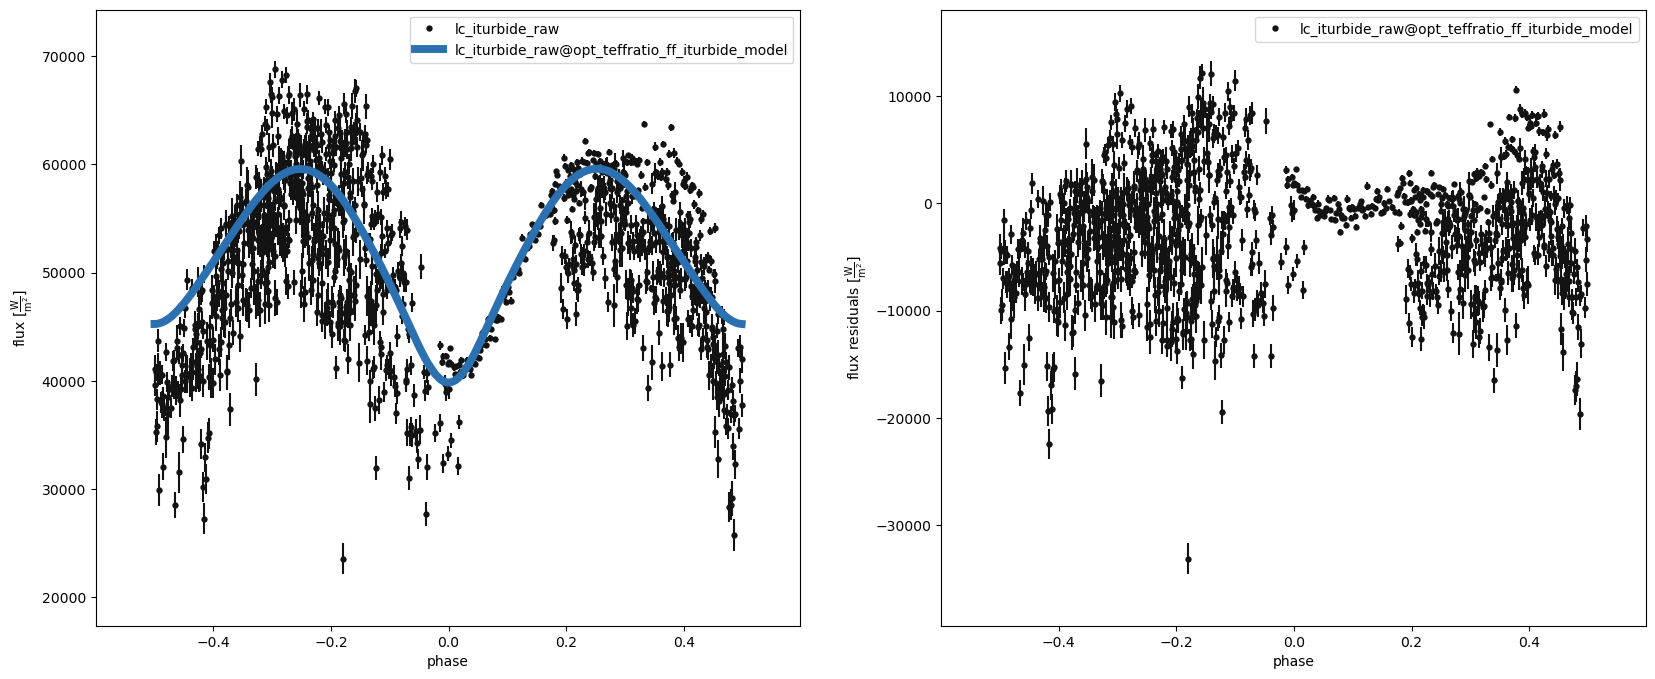

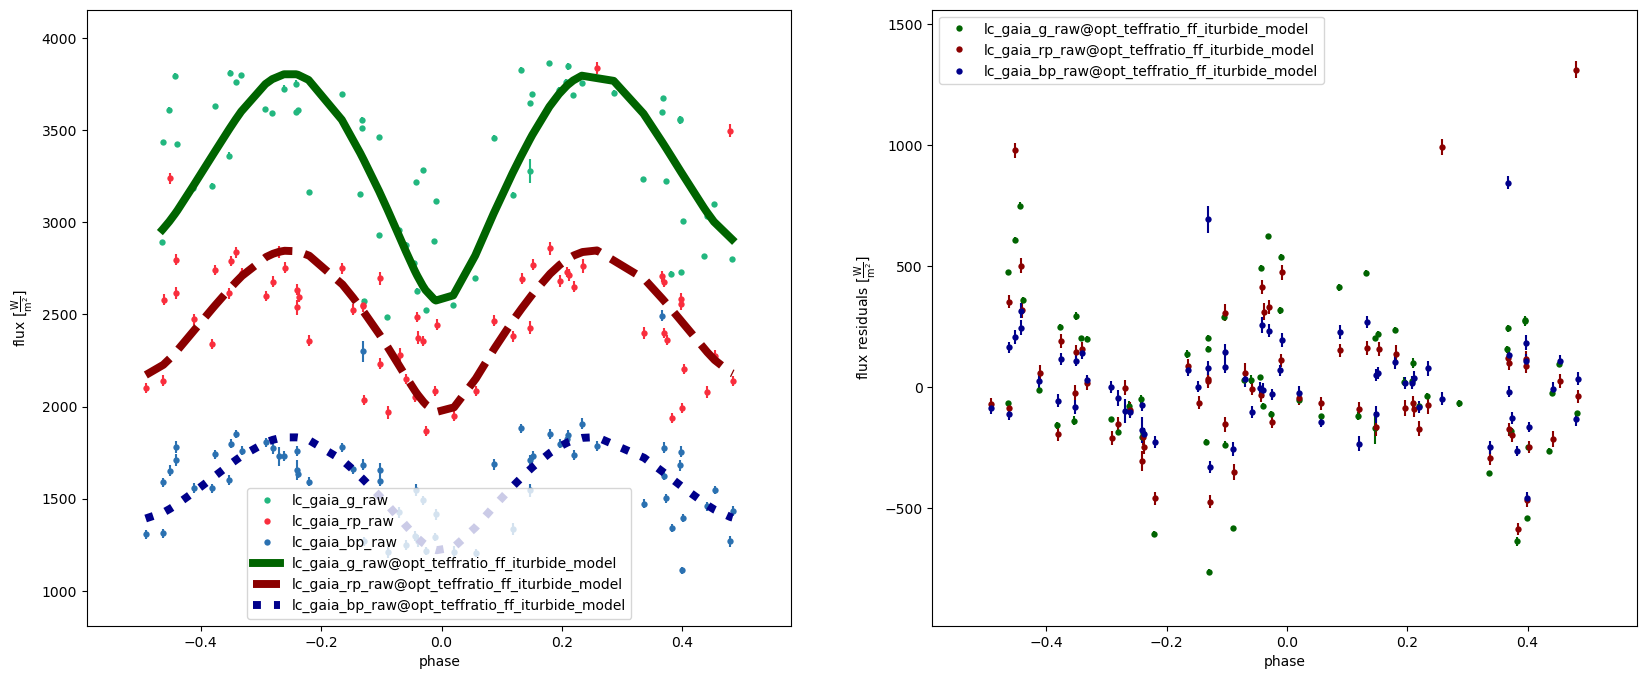

In [11]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_iturbide_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [12]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')
printChi2(b, 'opt_teffratio_ff_iturbide_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809


### All datasets (Iturbide + Gaia | Raw datasets)

In [17]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_rawdata', subfolder="differential-norm-estimates",
						  export=True, datasets=allRawDatasets, maxiter=250)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_teffratio_ff_rawdata.py ./results/opt_teffratio_ff_rawdata_solution


('opt_teffratio_ff_rawdata', 'opt_teffratio_ff_rawdata_solution')

Adopted:
teffratio@binary@orbit@component = 0.88006 
fillout_factor@contact_envelope@envelope@component = 0.17620 

Original values:
  teffratio@binary@orbit@component 0.9141943723937459
  fillout_factor@contact_envelope@envelope@component 0.29971777682780226


Fri, 22 Sep 2023 12:43 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:30<00:00,  6.72it/s]


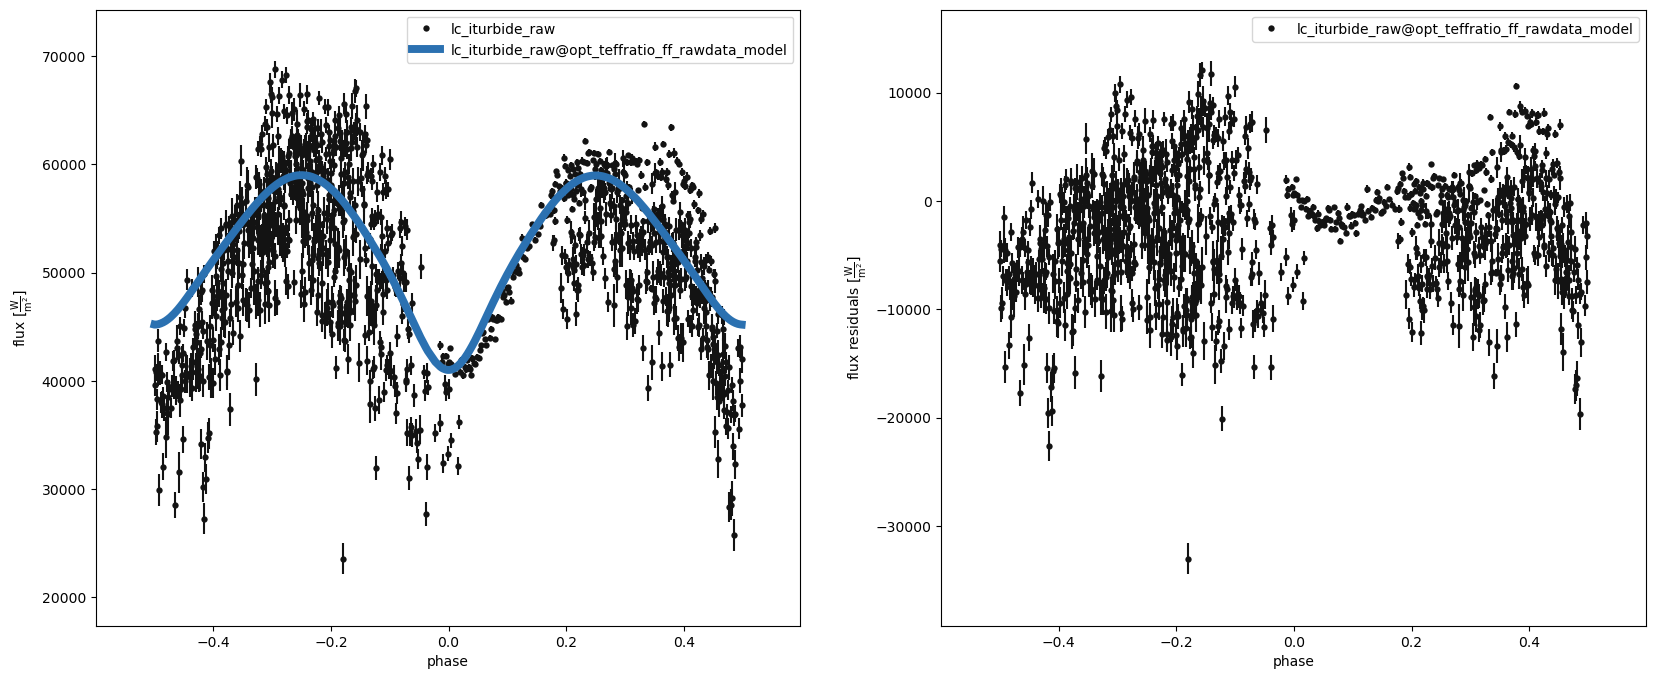

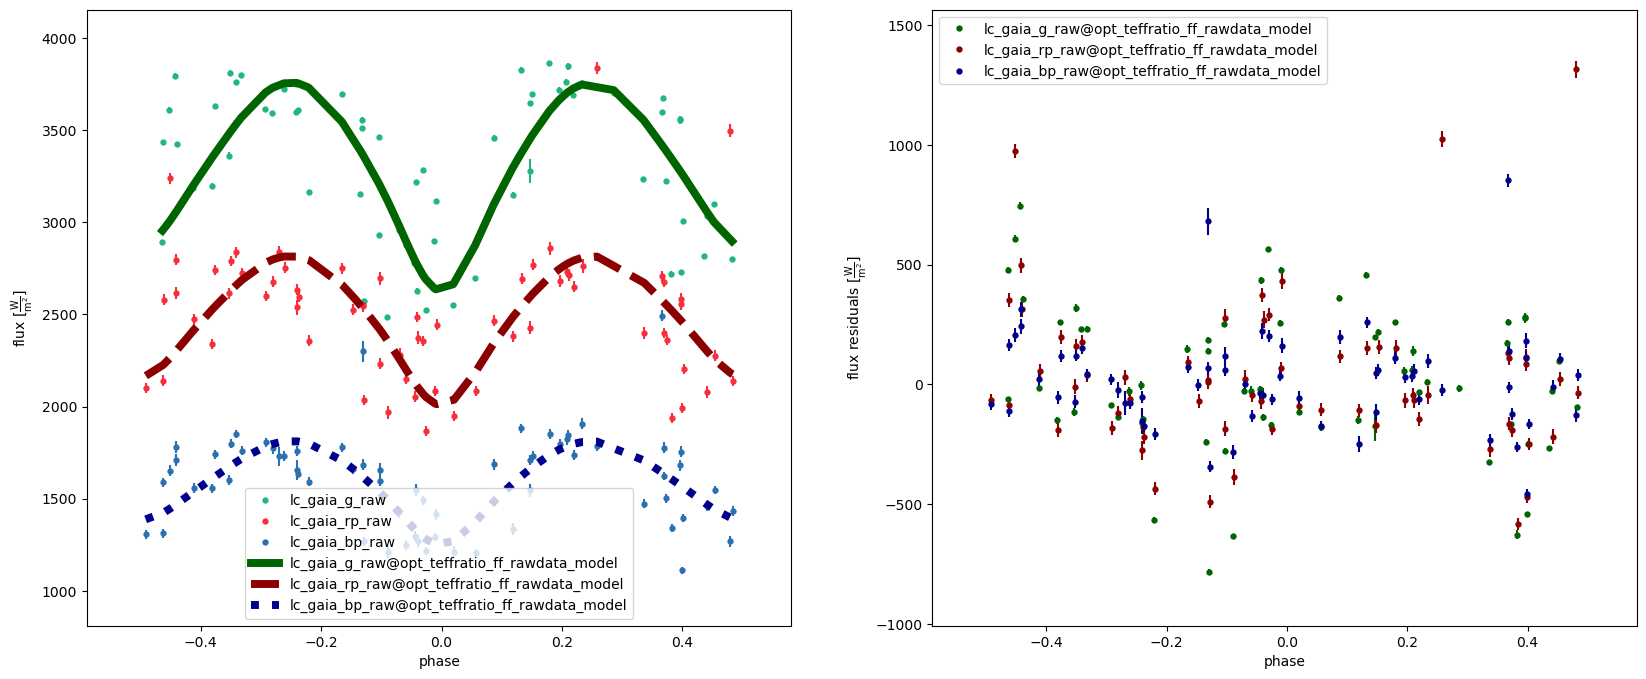

In [13]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_teffratio_ff_rawdata_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [14]:
for s in [s for s in b.solutions if 'opt_teffratio' in s]:
	print(s, "-----------------------------------", sep='\n')
	gen_utils.printFittedVals(b, s)
	print()

opt_teffratio_ff_gaiag_solution
-----------------------------------
teffratio@binary@orbit@component = 0.93269 
fillout_factor@contact_envelope@envelope@component = 0.04415 

opt_teffratio_ff_iturbide_solution
-----------------------------------
teffratio@binary@orbit@component = 0.85438 
fillout_factor@contact_envelope@envelope@component = 0.29482 

opt_teffratio_ff_rawdata_solution
-----------------------------------
teffratio@binary@orbit@component = 0.88006 
fillout_factor@contact_envelope@envelope@component = 0.17620 



In [15]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_teffratio_ff_gaiag_model')
printChi2(b, 'opt_teffratio_ff_iturbide_model')
printChi2(b, 'opt_teffratio_ff_rawdata_model')

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809
opt_teffratio_ff_rawdata_model
-------------------------------------
	 Iturbide - 53987.38877755462
	 Gaia - 69760.74606436273
		 lc_gaia_g_raw - 59287.22183331219
		 lc_gaia_rp_raw - 7117.912340210569
		 lc_gaia_bp_raw - 3355.6118908399603


In [9]:
print(b['per0'])

Parameter: per0@binary@component
                       Qualifier: per0
                     Description: Argument of periastron (defined at time t0@system)
                           Value: 0.0 deg
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, ecosw@binary@component, esinw@binary@component
                      Related to: t0_supconj@binary@component, period@binary@component, ecc@binary@component, dpdt@binary@component, dperdt@binary@component, t0@system, t0_perpass@binary@component, t0_ref@binary@component, ecosw@binary@component, esinw@binary@component



Fri, 22 Sep 2023 12:47 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:29<00:00,  6.75it/s]


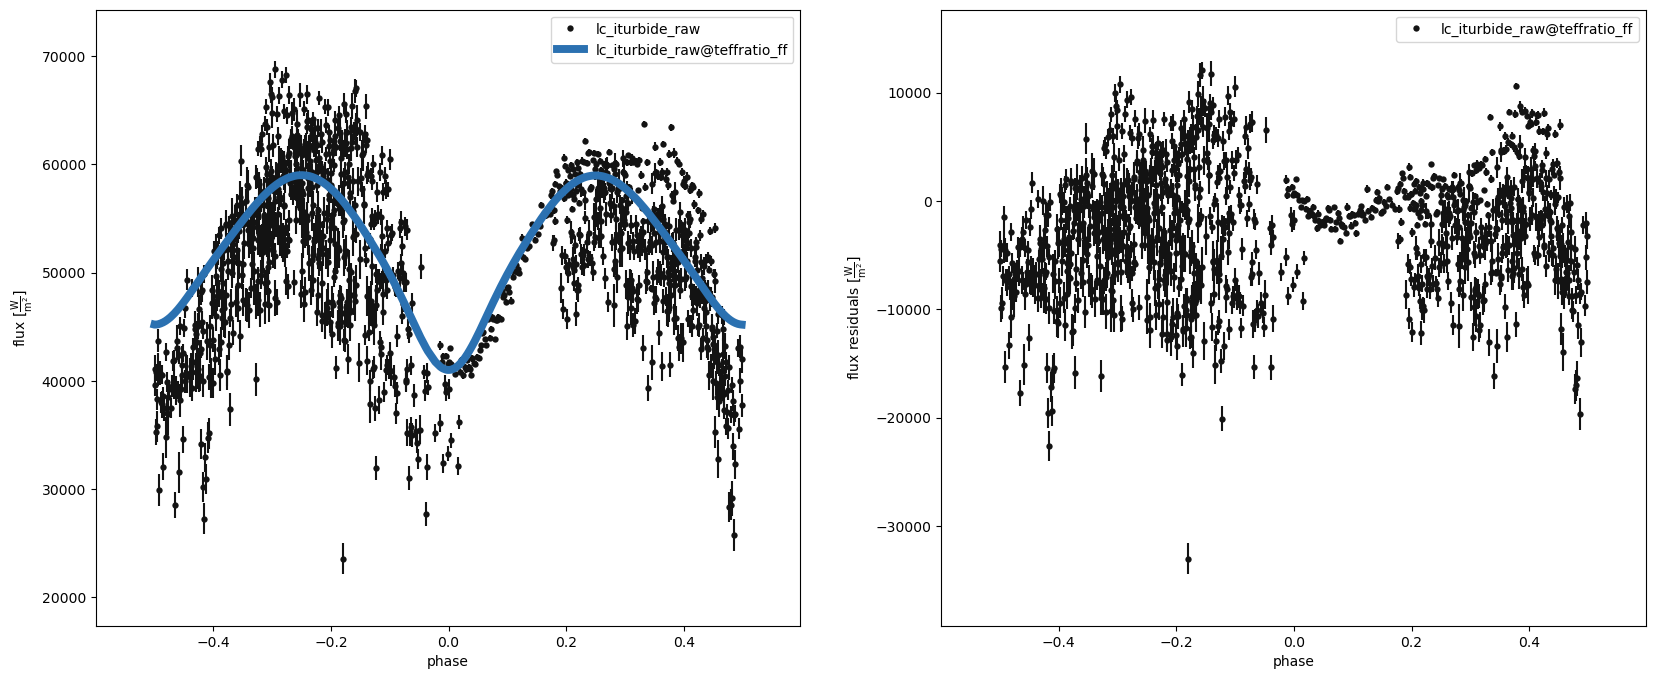

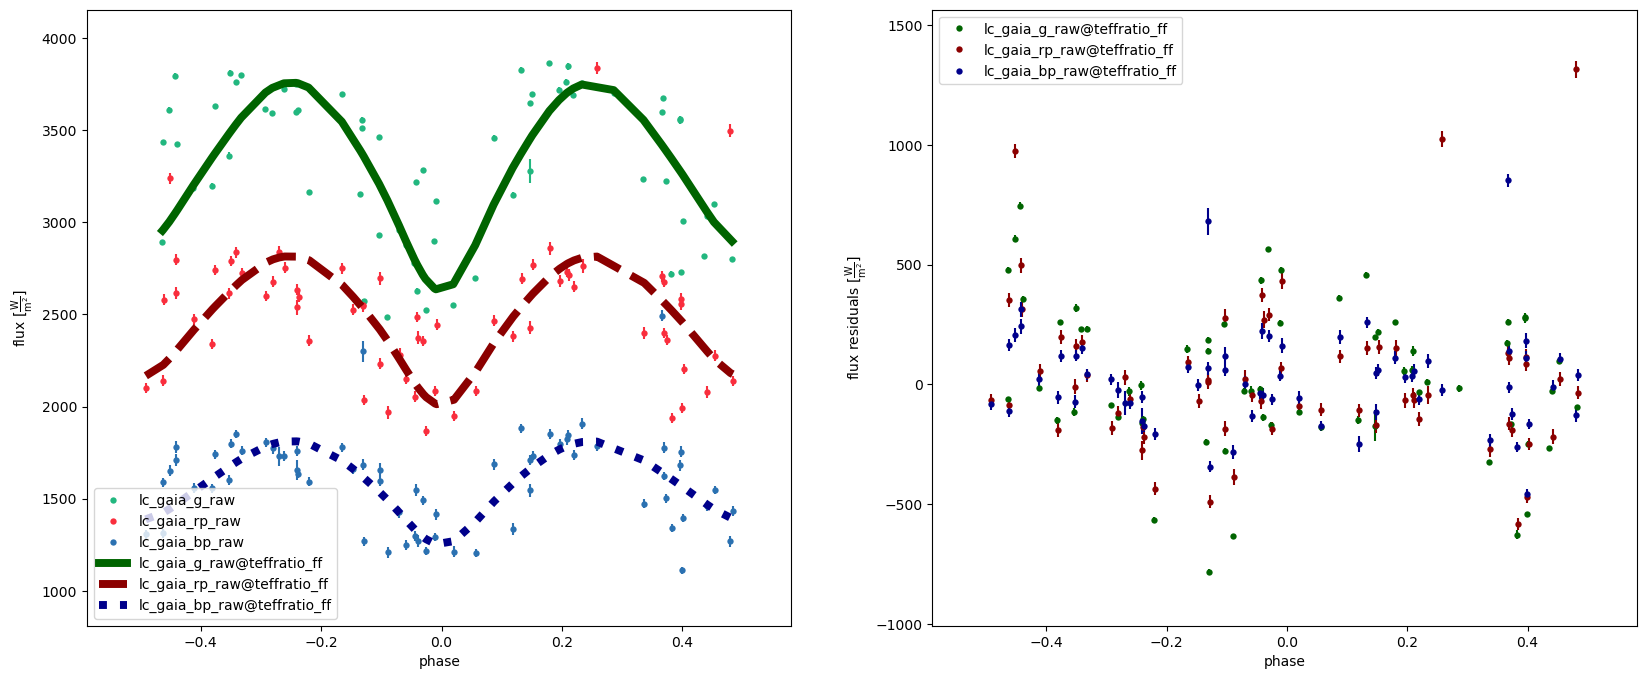

In [16]:
b.adopt_solution("opt_teffratio_ff_rawdata_solution")
b.run_compute(model="teffratio_ff", overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model="teffratio_ff", 
									legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

### Argument of periastron `per0`

Seeing what effect (if any) this has on the resulting light curve. Maybe it can get rid of the weird behavior at the Iturbide LC's extremes?

**Conclusion**: no appreciable effect on this light curve

In [10]:
# testing out with different combos of LCs, to see if they have any effect
print(opt_utils.optimize_params(b, fit_twigs=['per0'], label='per0', export=True, subfolder="differential-norm-estimates/per0", datasets=allRawDatasets))
print(opt_utils.optimize_params(b, fit_twigs=['per0'], label='per0_iturbide', export=True, subfolder="differential-norm-estimates/per0", datasets=['lc_iturbide_raw']))
print(opt_utils.optimize_params(b, fit_twigs=['per0'], label='per0_gaia', export=True, subfolder="differential-norm-estimates/per0", datasets=rawGaiaDatasets))

External Solver: ./external-jobs/differential-norm-estimates/per0/optimizer.nelder_mead_opt_per0.py ./results/opt_per0_solution
('opt_per0', 'opt_per0_solution')
External Solver: ./external-jobs/differential-norm-estimates/per0/optimizer.nelder_mead_opt_per0_iturbide.py ./results/opt_per0_iturbide_solution
('opt_per0_iturbide', 'opt_per0_iturbide_solution')
External Solver: ./external-jobs/differential-norm-estimates/per0/optimizer.nelder_mead_opt_per0_gaia.py ./results/opt_per0_gaia_solution
('opt_per0_gaia', 'opt_per0_gaia_solution')


Adopted:
per0@binary@orbit@component = 0.00000 deg

Original values:
  per0@binary@orbit@component 0.0 deg


Fri, 22 Sep 2023 12:50 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:32<00:00,  6.65it/s]


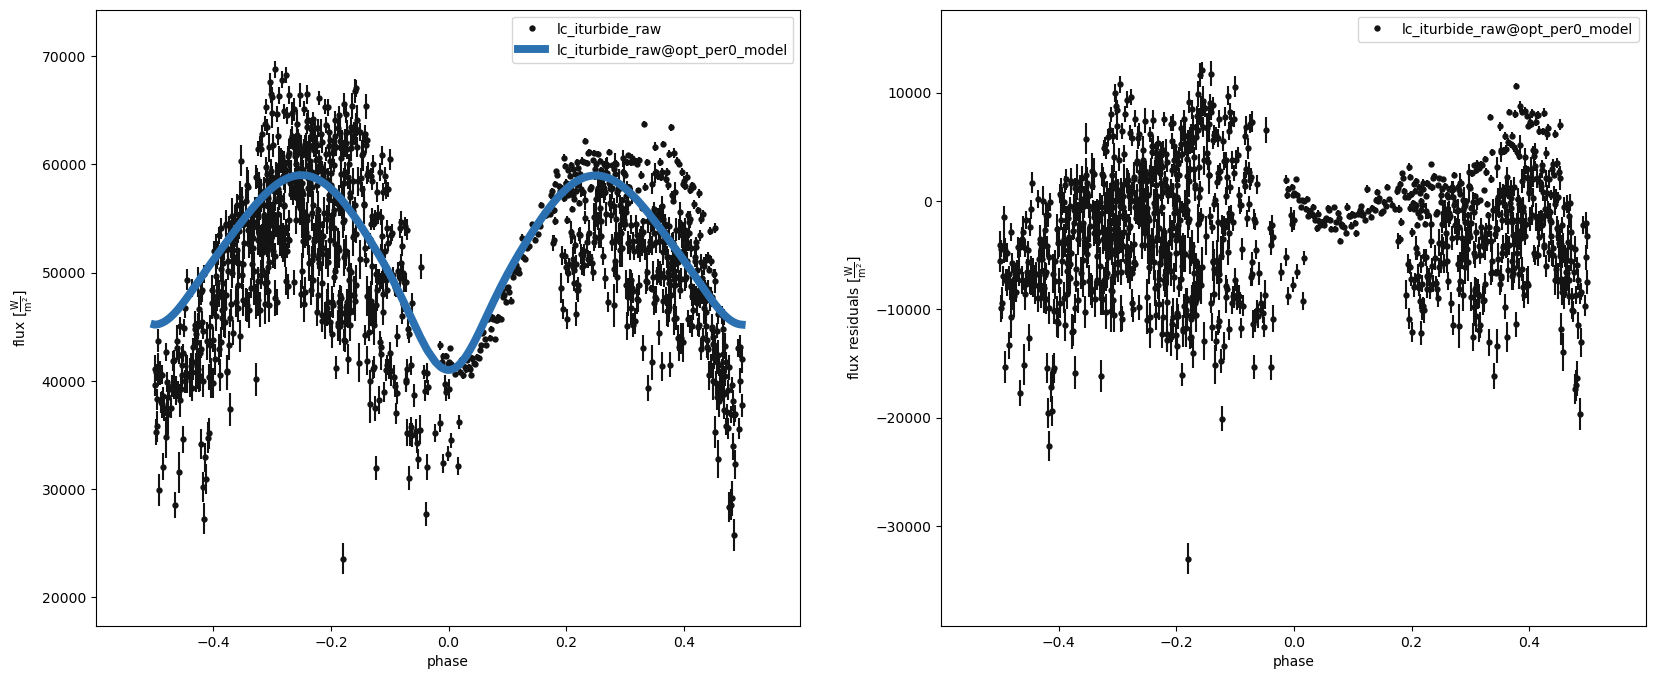

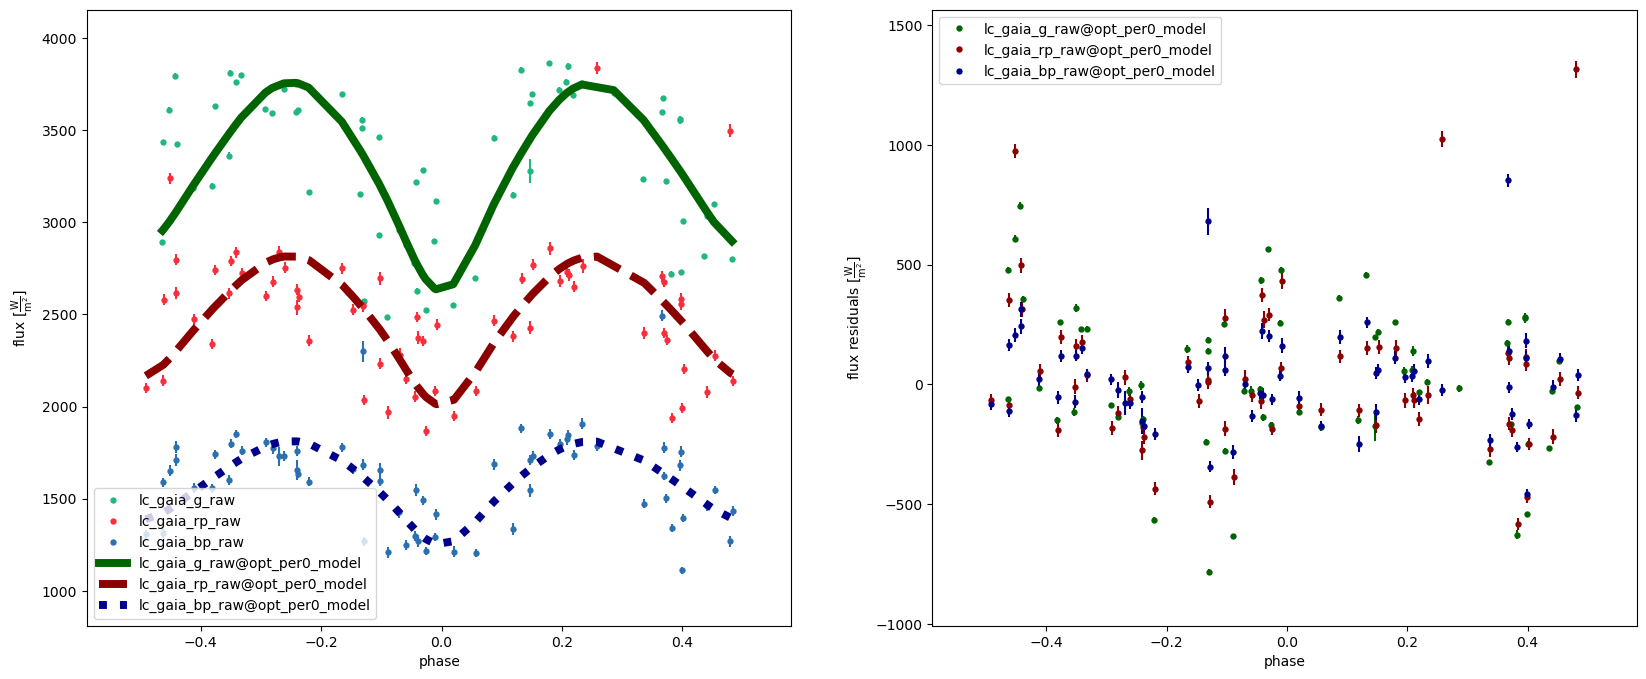

Adopted:
per0@binary@orbit@component = 0.00063 deg

Original values:
  per0@binary@orbit@component 0.0 deg


Fri, 22 Sep 2023 12:54 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:32<00:00,  6.67it/s]


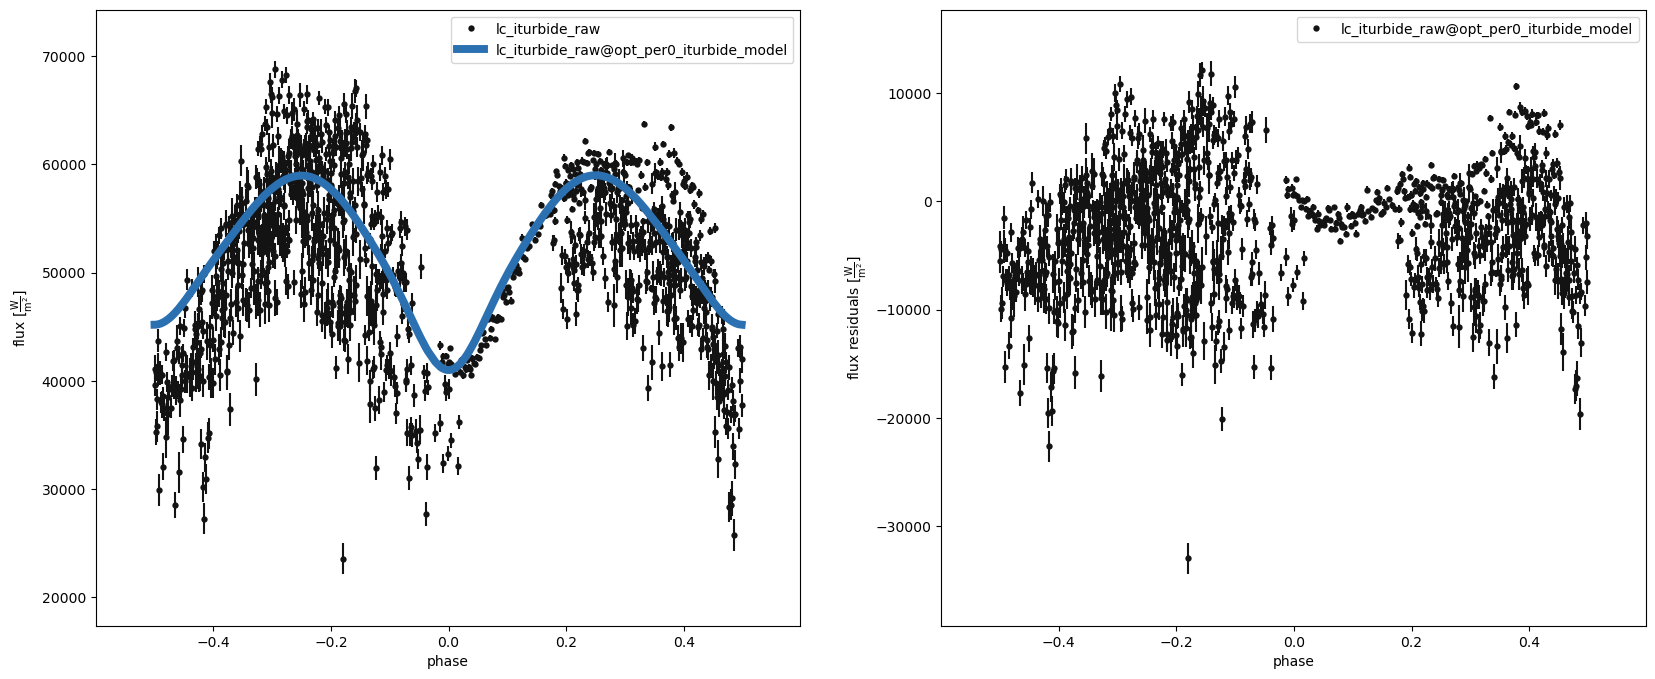

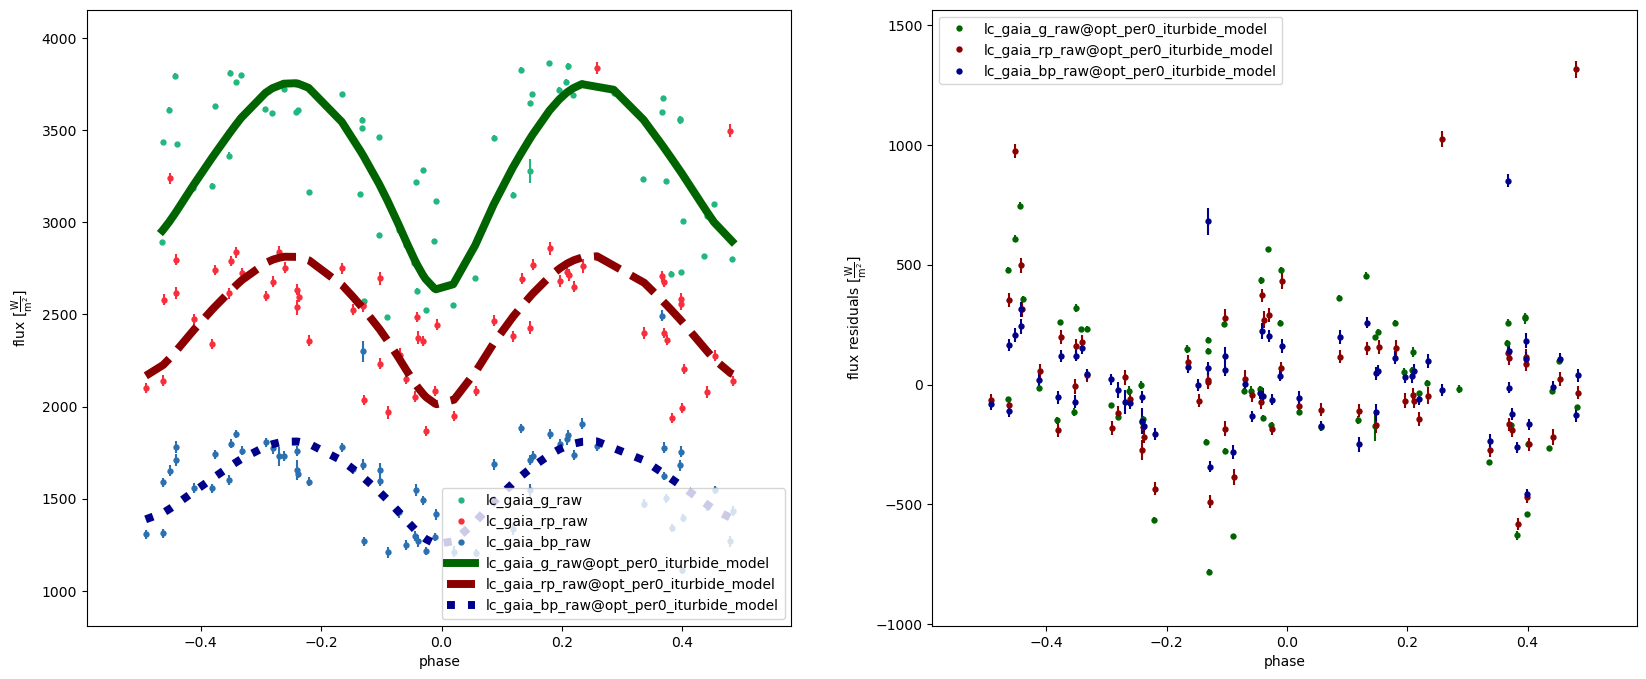

Adopted:
per0@binary@orbit@component = 0.00028 deg

Original values:
  per0@binary@orbit@component 0.0 deg


Fri, 22 Sep 2023 12:58 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:32<00:00,  6.66it/s]


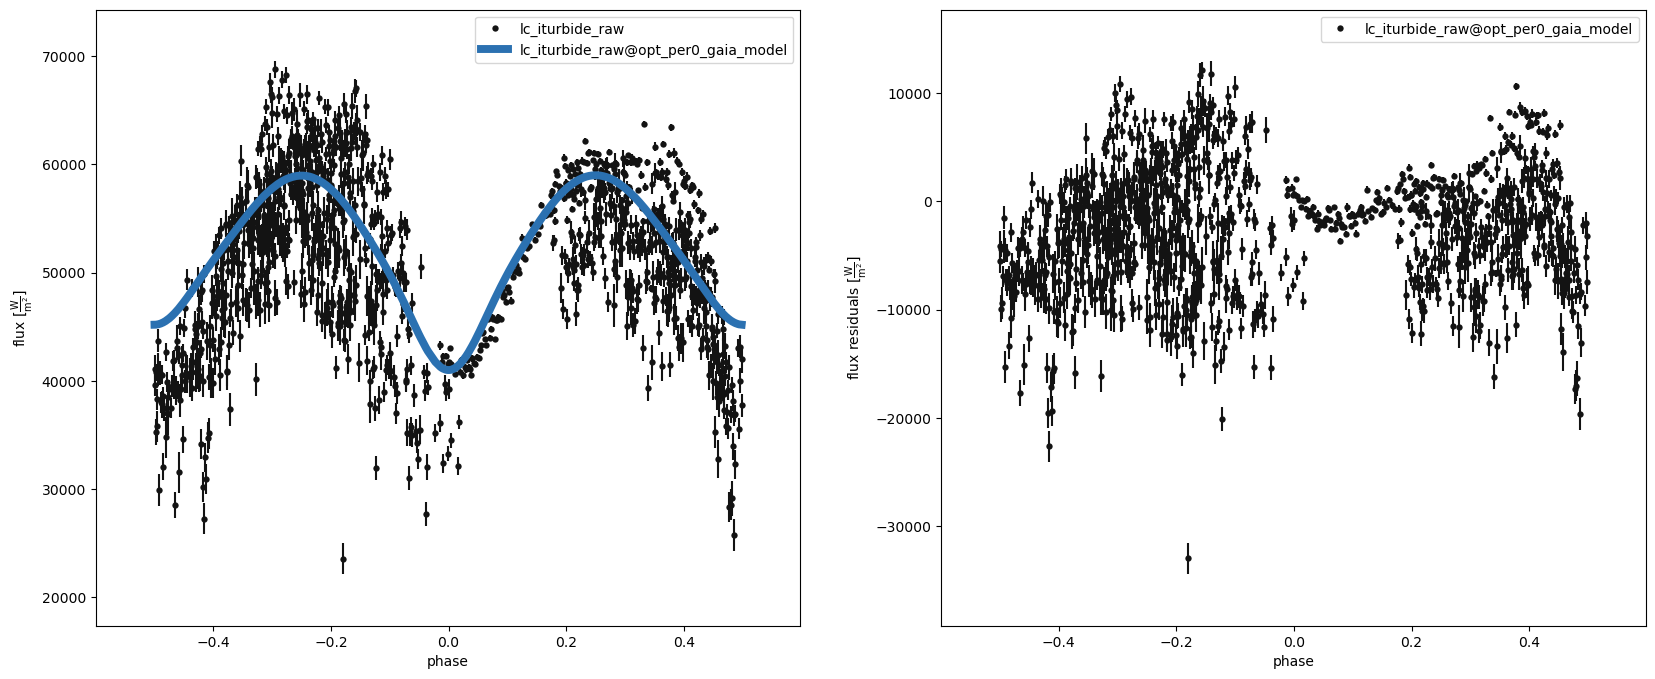

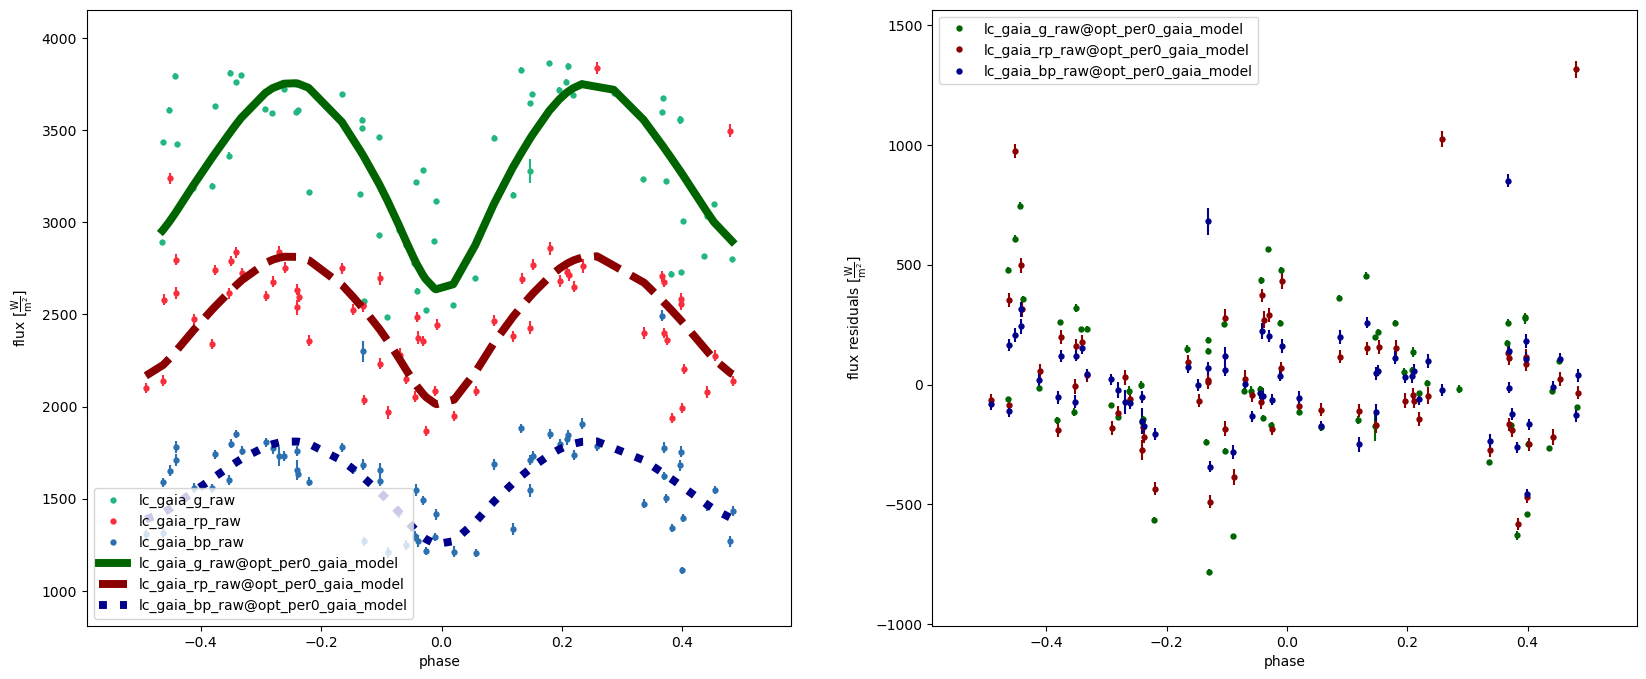

In [17]:
folderPath = "./external-jobs/differential-norm-estimates/per0/results"
for solFile in os.listdir(folderPath):
	solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file=os.path.join(folderPath, solFile), reset_params=True, plot=False)
	gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

# no significant change in the end; not adopting any of these solutions

## Including `teff@primary` to allow primary temperature to keep changing

Further adjustment to eclipses

In [3]:
b = phoebe.load("./bundle-saves/full-diff-data/dataset-scaled-optimized")

In [19]:
backupBundle = b.copy()

In [20]:
print(b['teff@primary'])
print(b['teffratio'])

Parameter: teff@primary@component
                       Qualifier: teff
                     Description: Mean effective temperature
                           Value: 6000.0 K
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teffratio@binary@component, teff@secondary@component

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.8800597213958596
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component



In [21]:
opt_utils.optimize_params(b, fit_twigs=['teff@primary', 'teffratio', 'fillout_factor'], label='tp_tr_ff', export=True, 
						  subfolder='differential-norm-estimates', datasets=allRawDatasets, 
						  maxiter=250)

Fri, 22 Sep 2023 13:56 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.


External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_tp_tr_ff.py ./results/opt_tp_tr_ff_solution


('opt_tp_tr_ff', 'opt_tp_tr_ff_solution')

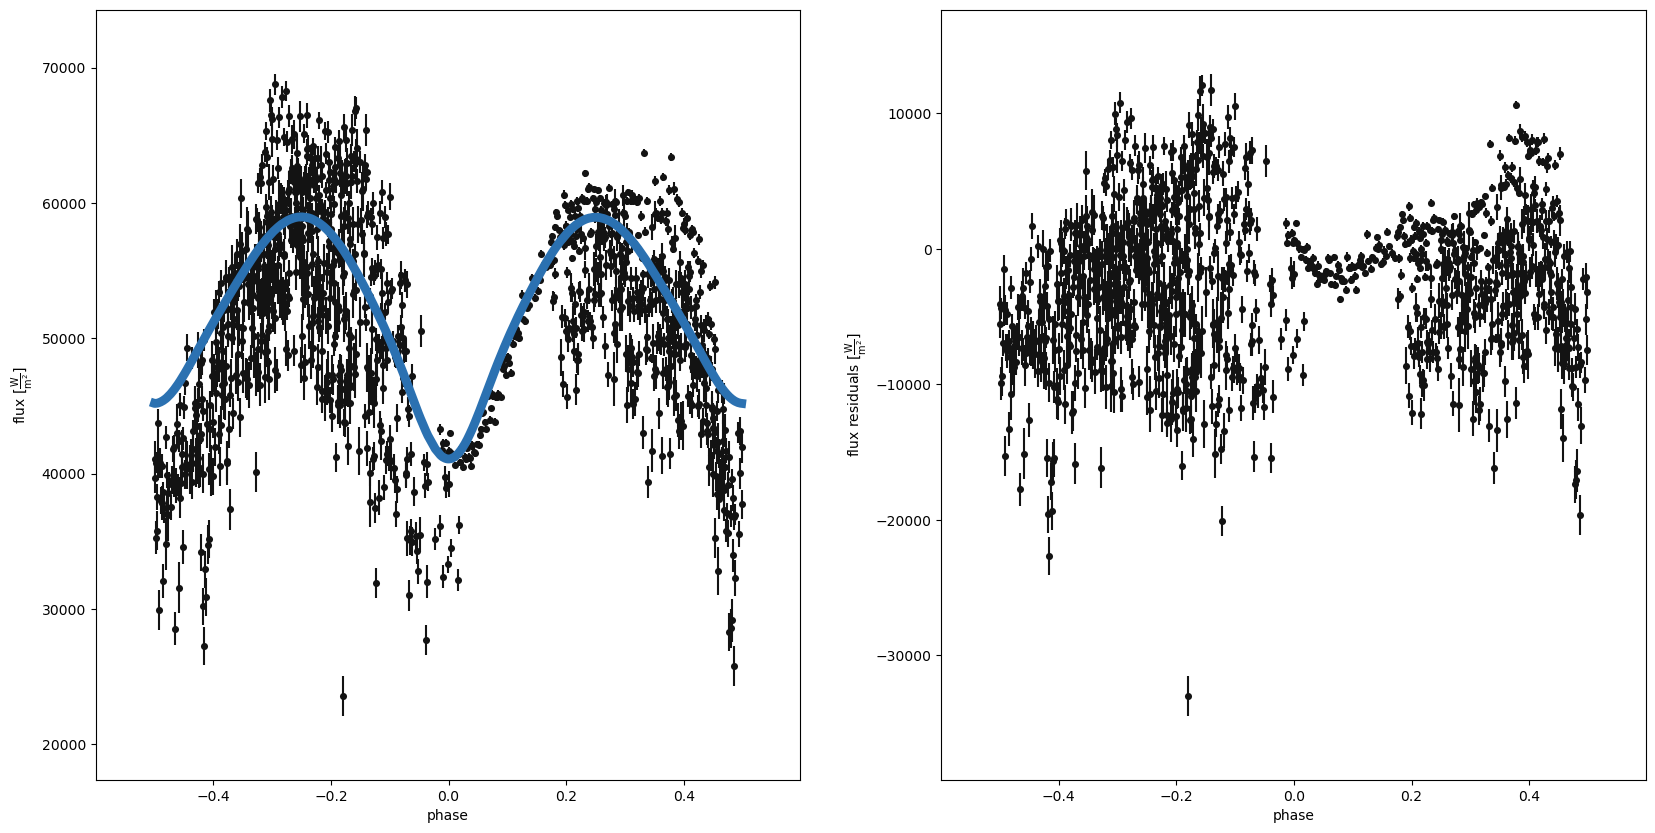

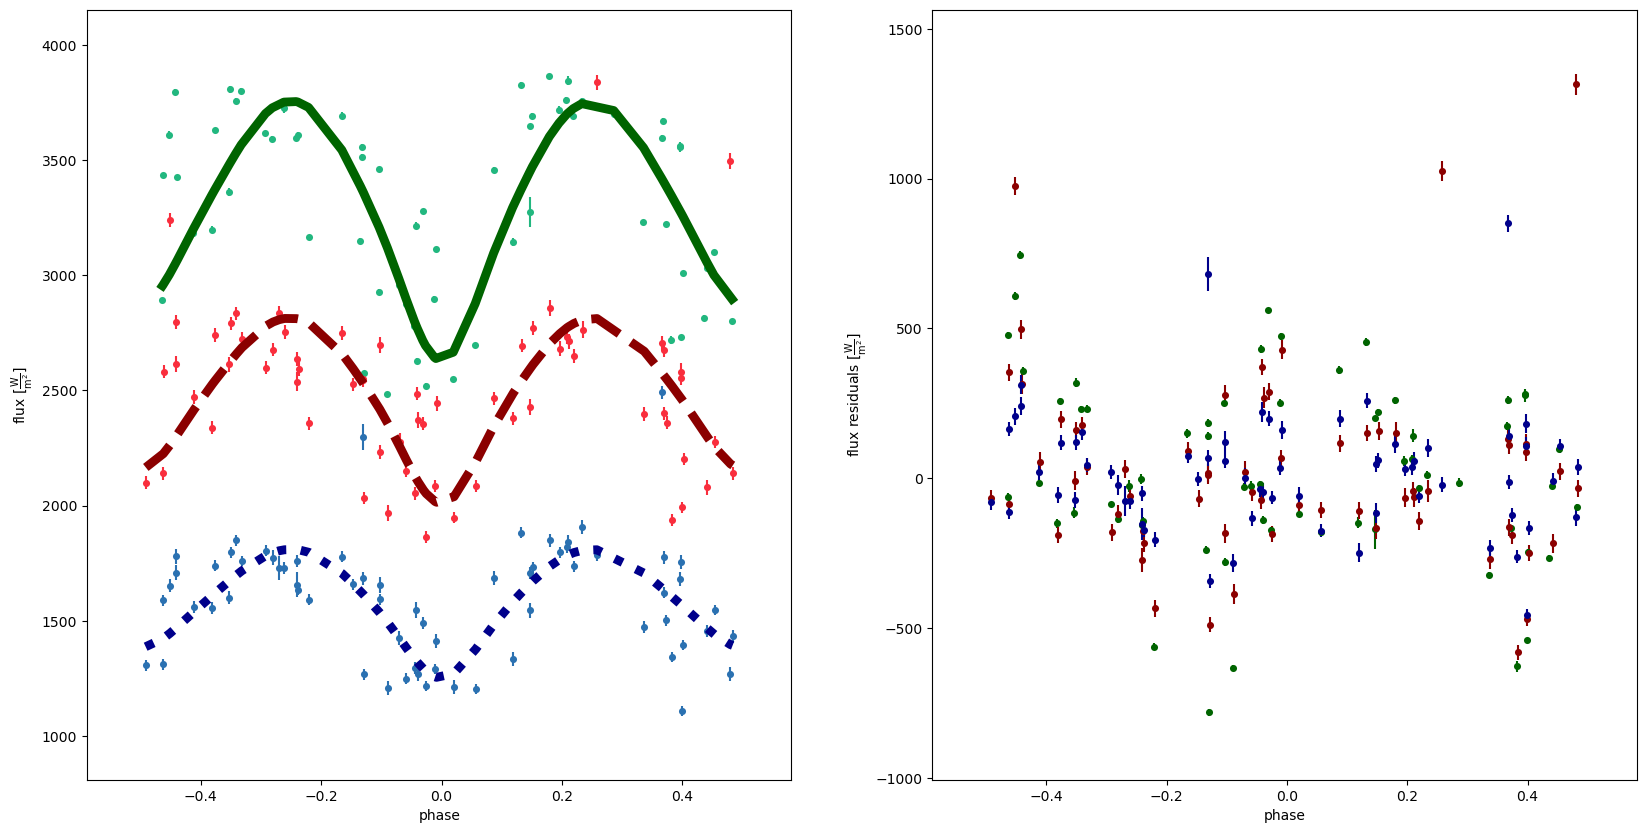

opt_tp_tr_ff_model
-------------------------------------
	 Iturbide - 54061.41408453537
	 Gaia - 69658.09026204859
		 lc_gaia_g_raw - 59188.90906520911
		 lc_gaia_rp_raw - 7114.535337049358
		 lc_gaia_bp_raw - 3354.6458597901174


In [34]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/differential-norm-estimates/results/opt_tp_tr_ff_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(20,10), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS)
printChi2(b, computeModelName)

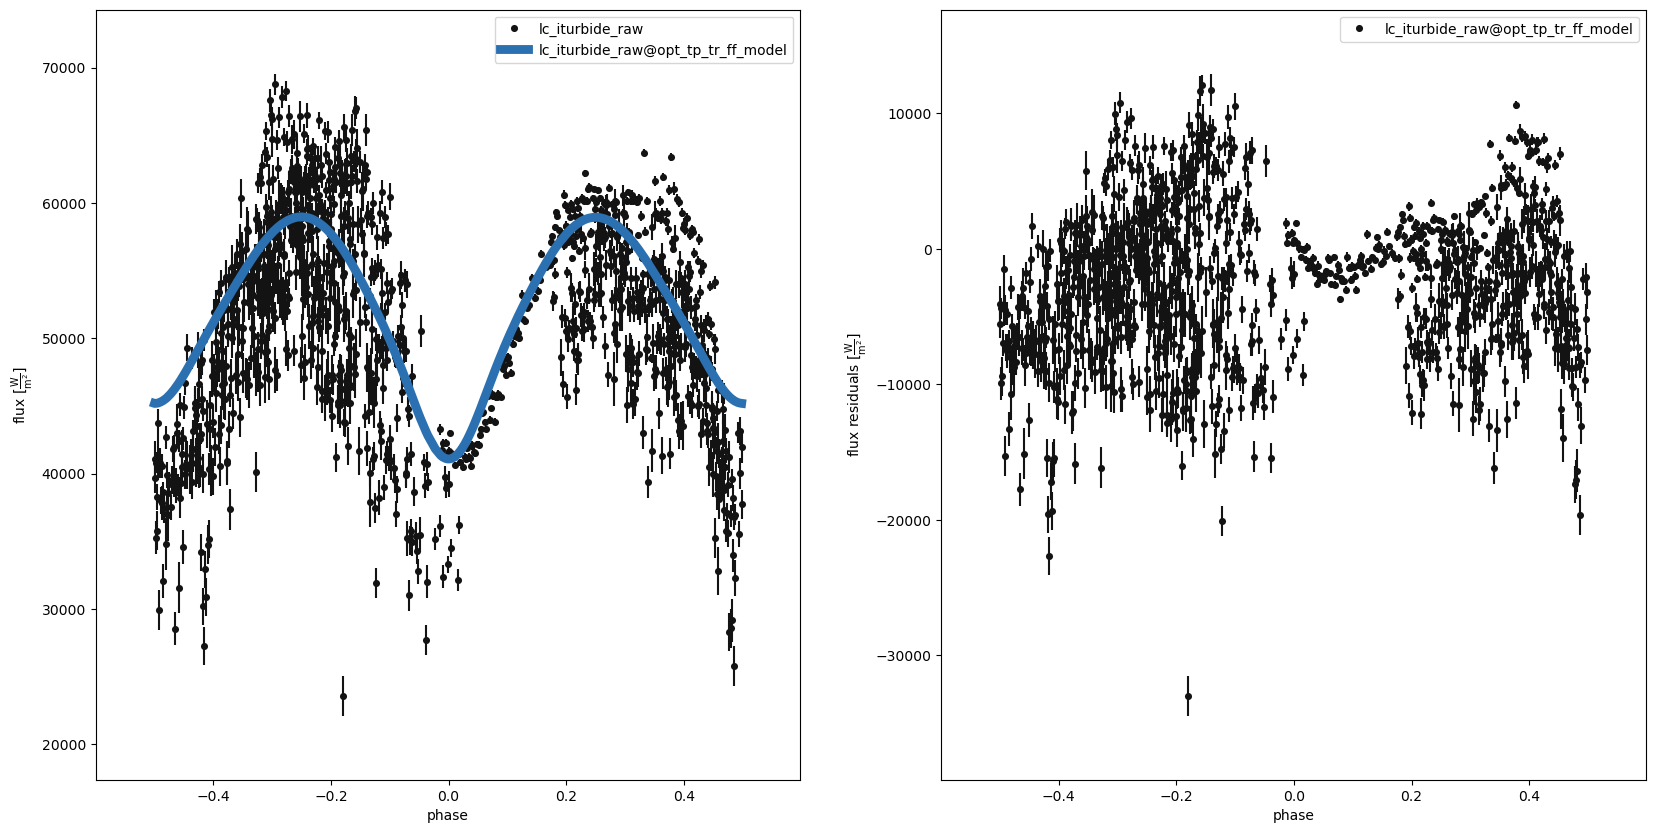

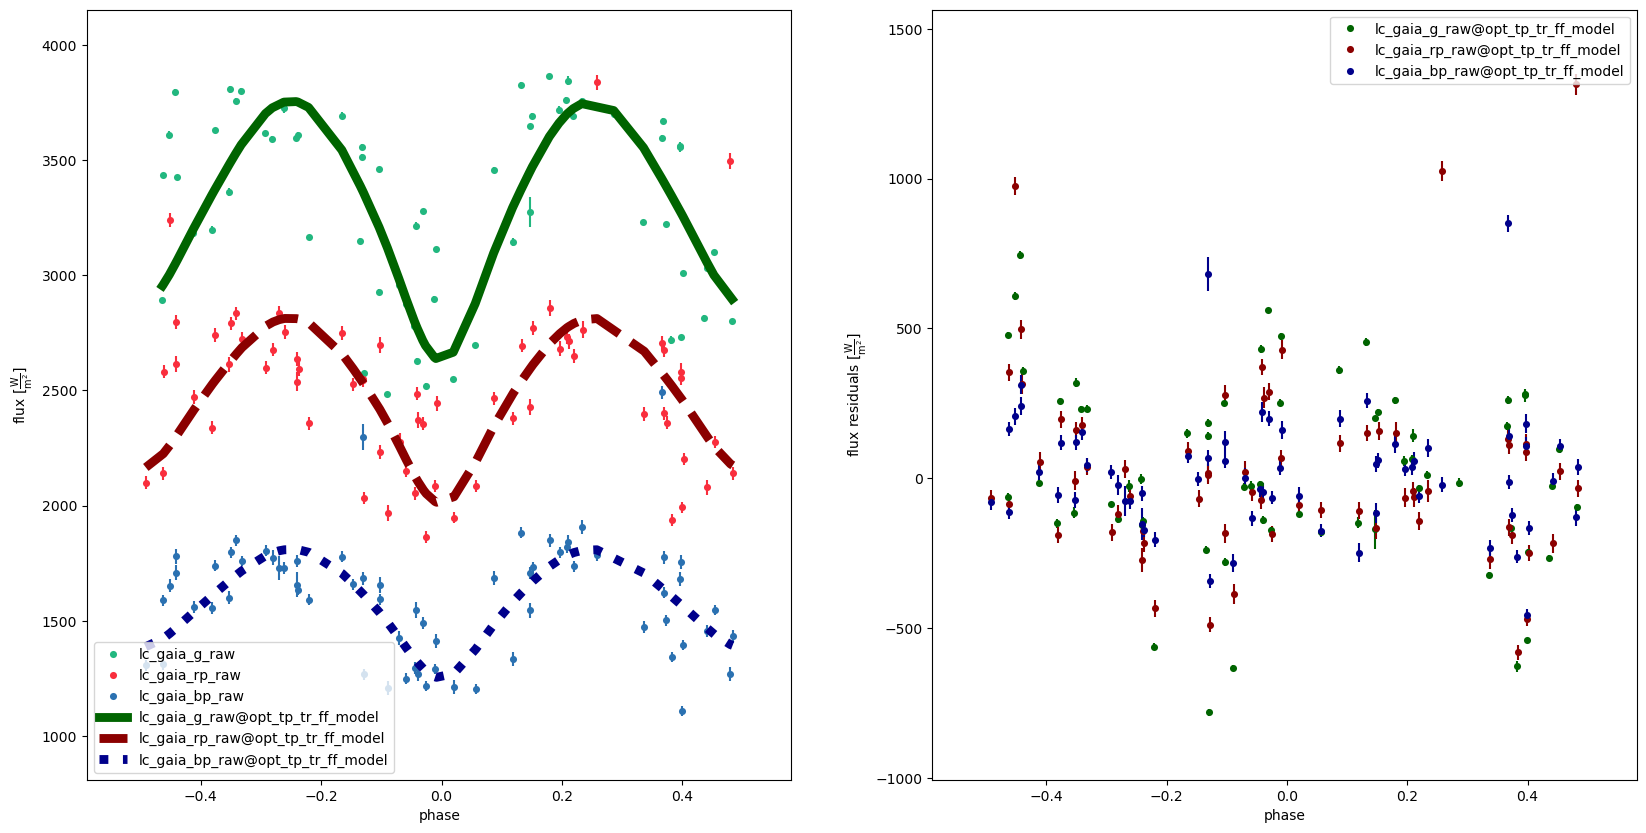

In [11]:
gen_utils.plotModelResidualsFigsize(b, figsize=(20,10), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model='opt_tp_tr_ff_model', color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)

In [46]:
gen_utils.animateMesh(b, logger)

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [37]:
for m in b.models:
	printChi2(b, m)
	print()

before_optimizers
-------------------------------------
	 Iturbide - 80372.93667258961
	 Gaia - 80636.72905834304
		 lc_gaia_g_raw - 68451.7403163134
		 lc_gaia_rp_raw - 8305.402354532449
		 lc_gaia_bp_raw - 3879.5863874971974

opt_period_t0_model
-------------------------------------
	 Iturbide - 53814.131326098206
	 Gaia - 71473.99161458347
		 lc_gaia_g_raw - 60687.52617008204
		 lc_gaia_rp_raw - 7373.135091822414
		 lc_gaia_bp_raw - 3413.330352679013

opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 58846.734770438925
	 Gaia - 68442.83153534197
		 lc_gaia_g_raw - 57901.41475907322
		 lc_gaia_rp_raw - 7139.2681842022275
		 lc_gaia_bp_raw - 3402.148592066532

opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 52991.952262979496
	 Gaia - 72771.86102981483
		 lc_gaia_g_raw - 62131.844317668496
		 lc_gaia_rp_raw - 7246.9434312625235
		 lc_gaia_bp_raw - 3393.073280883809

opt_teffratio_ff_rawdata_model
------------------------

## Checkpoint

In [55]:
gen_utils.saveBundle(b, "dataset-scaled-optimized", subfolder="full-diff-data")

'bundle-saves/full-diff-data/dataset-scaled-optimized'

## Adjusting the passband luminosity

Will be trying to adjust the passband luminosity for both the Iturbide light curve as well as the Gaia G light curve. To preserve the colors,
Gaia BP and RP will be set to scale to Gaia G (if possible).

In [6]:
b = phoebe.load("./bundle-saves/full-diff-data/dataset-scaled-optimized")

In [7]:
pb_backup = b.copy()

In [ ]:
%%script echo "skip unless need to restore backup"
b = pb_backup.copy()

In [8]:
b.set_value(qualifier='pblum_mode', dataset='lc_iturbide_raw', value='component-coupled')
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_g_raw', value='component-coupled')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_rp_raw', value='dataset-coupled')
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_raw', value='dataset-coupled')

# coupling gaia datasets together
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_rp_raw', value='lc_gaia_g_raw')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_raw', value='lc_gaia_g_raw')

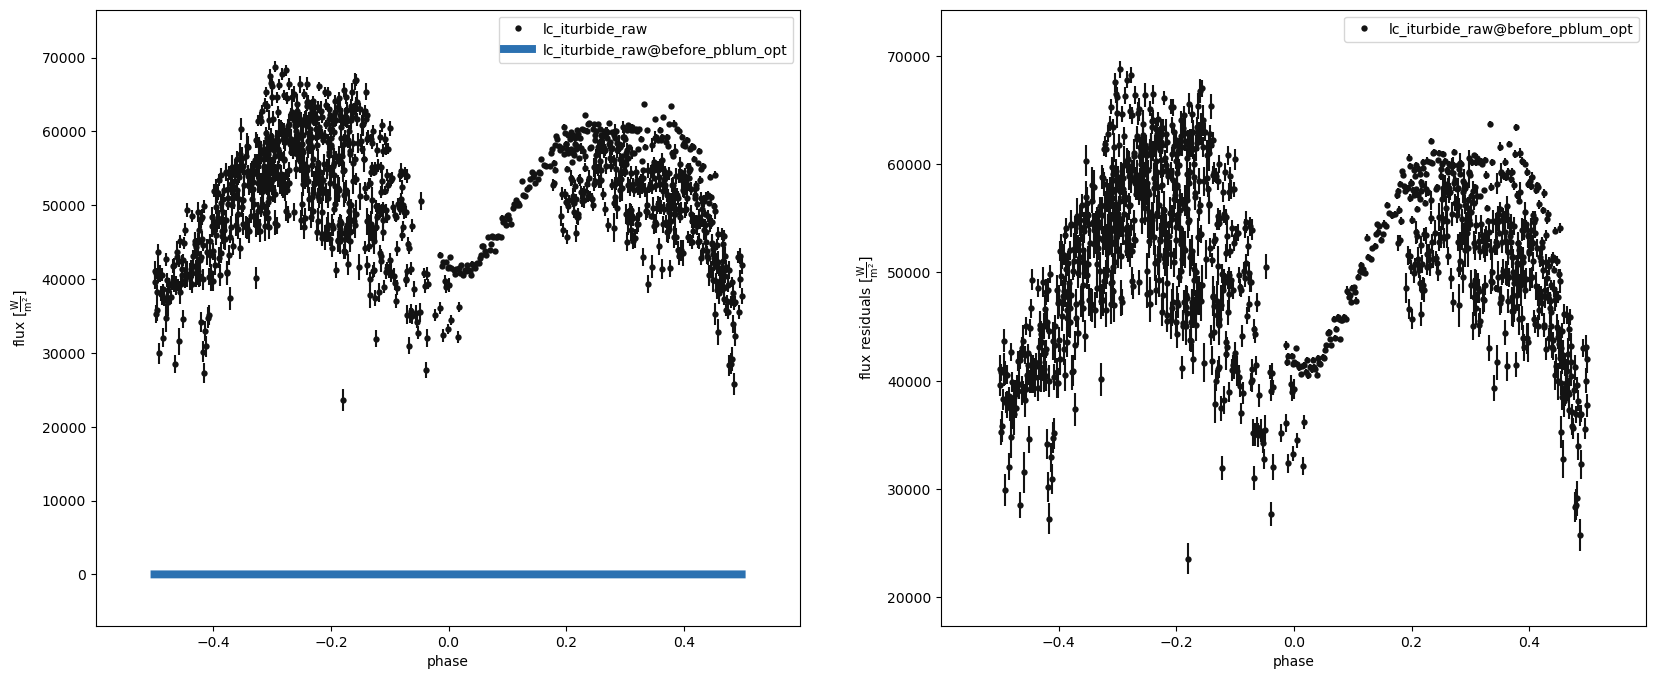

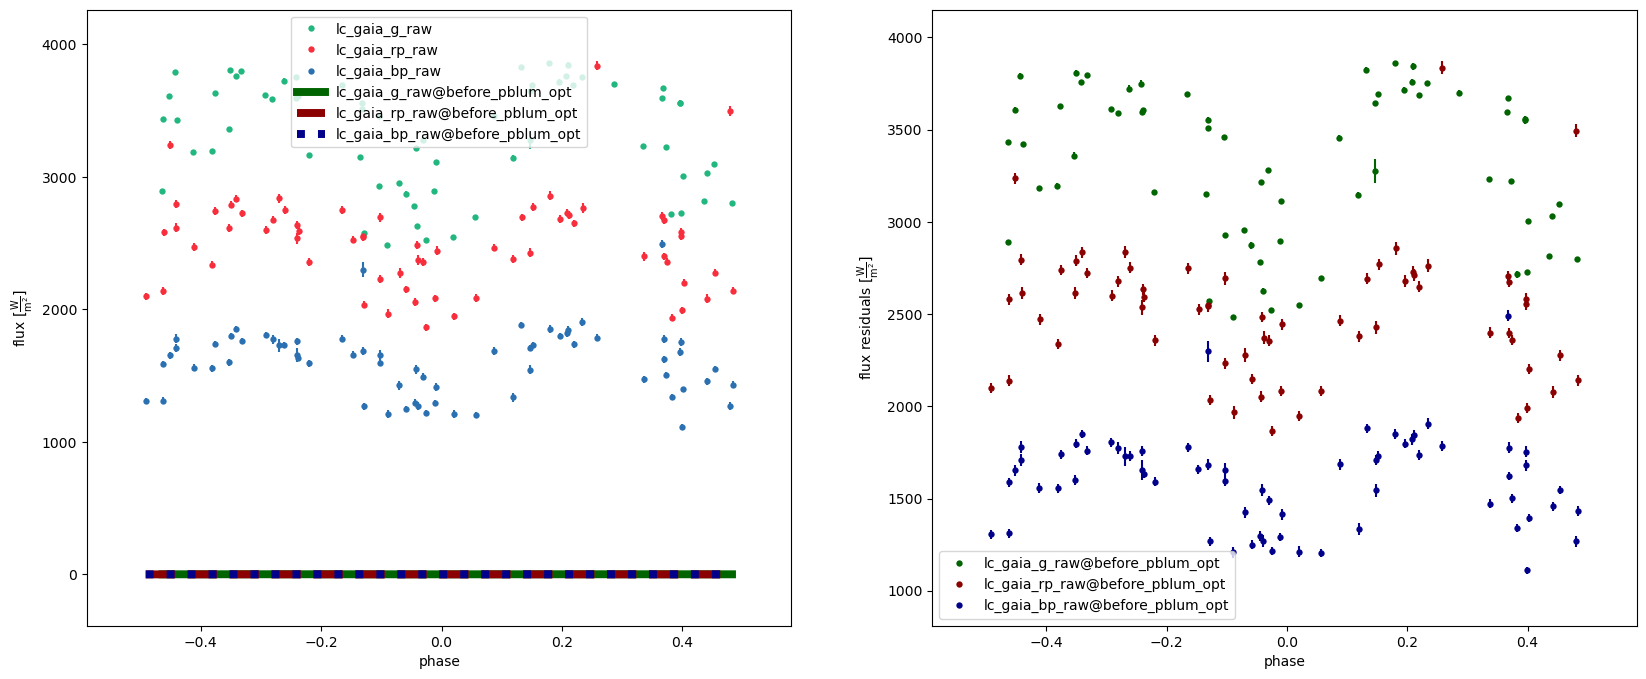

In [10]:
b.run_compute(model='before_pblum_opt', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=[['lc_iturbide_raw'], rawGaiaDatasets], model='before_pblum_opt', color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [14]:
print(b['pblum']) # equal to 4*pi

ParameterSet: 2 parameters
   pblum@primary@lc_iturbide_r...: 12.566370614359172 W
   pblum@primary@lc_gaia_g_raw...: 12.566370614359172 W


In [8]:
opt_utils.optimize_params(b, label='pblum_iturbide', export=True, subfolder='differential-norm-estimates', 
						  fit_twigs=['pblum@lc_iturbide_raw@primary'], datasets=['lc_iturbide_raw'])
opt_utils.optimize_params(b, label='pblum_gaia', export=True, subfolder='differential-norm-estimates', 
						  fit_twigs=['pblum@lc_gaia_g_raw@primary'], datasets=rawGaiaDatasets)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_pblum_iturbide.py ./results/opt_pblum_iturbide_solution
External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_pblum_gaia.py ./results/opt_pblum_gaia_solution


('opt_pblum_gaia', 'opt_pblum_gaia_solution')

In [12]:
opt_utils.adopt_solution(b, reset_params=True, solution_file="./external-jobs/differential-norm-estimates/results/opt_pblum_gaia_solution", plot=False)

Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset = 29034.10559 W

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 1414/1414 [04:05<00:00,  5.76it/s]


AdoptSolutionResult(solutionName='opt_pblum_gaia_solution', computeModelName='opt_pblum_gaia_model')

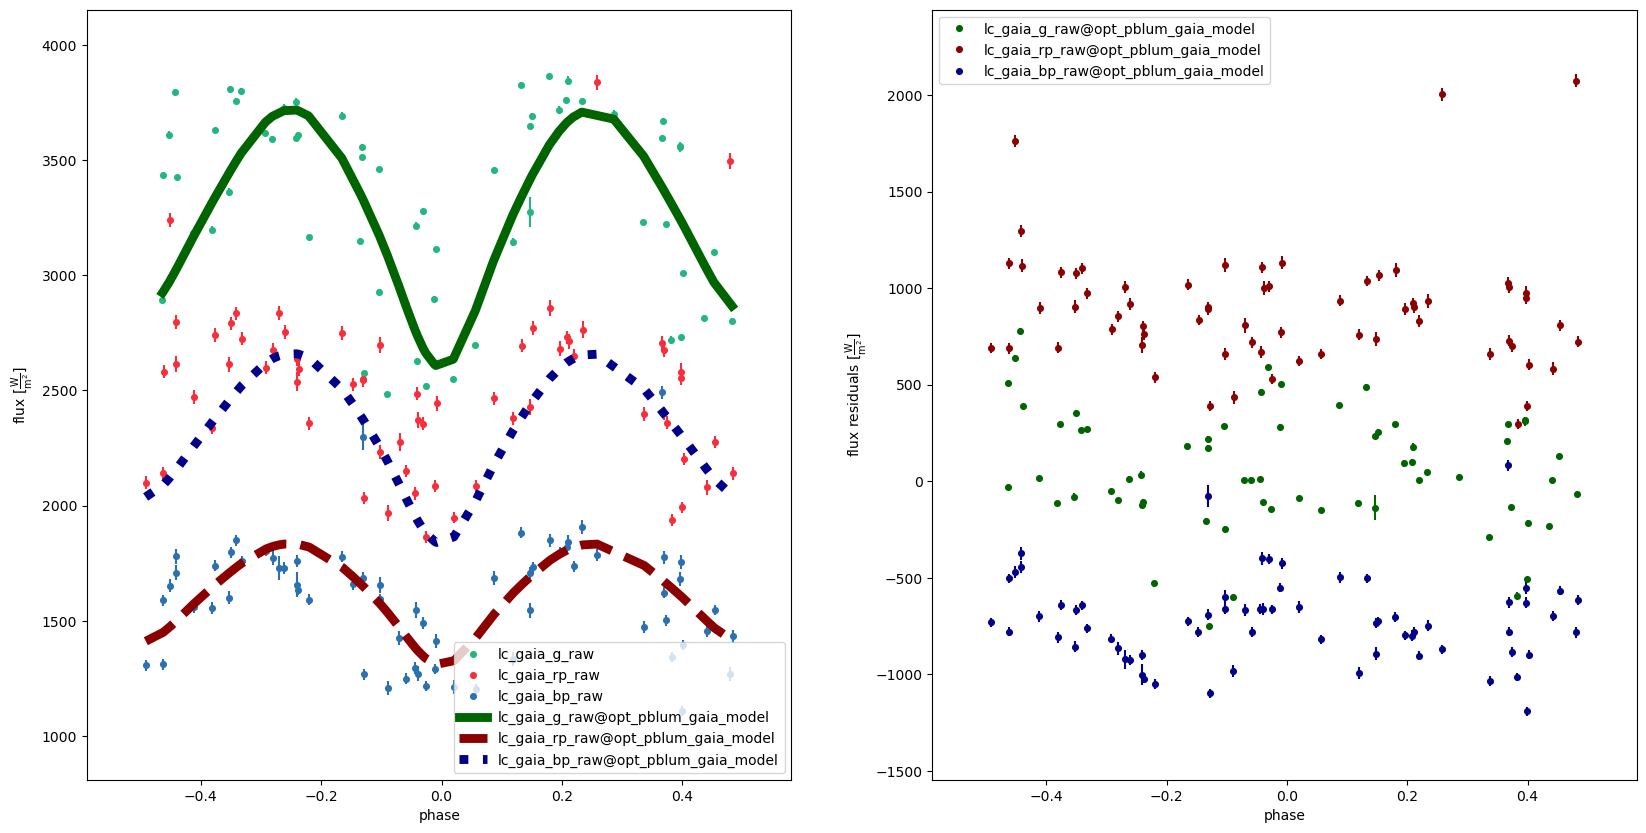

In [13]:
gen_utils.plotModelResidualsFigsize(b, (20,10), [rawGaiaDatasets], 'opt_pblum_gaia_model', legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS)

### Correcting `teffratio` with new passband luminosities from Gaia

Gaia colors look to be inverted, thinking it's a problem with the component temperatures

In [15]:
print(b['teffratio'])
print(b['teff@primary'])

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.8800597213958596
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

Parameter: teff@primary@component
                       Qualifier: teff
                     Description: Mean effective temperature
                           Value: 6000.0 K
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teffratio@binary@component, teff@secondary@component



In [17]:
# trying also optimizing pblum at the same time, just in case there is any effect
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary'], label='tr_tprim_pbgaiag', export=True,
						  subfolder='differential-norm-estimates', datasets=rawGaiaDatasets)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_tr_tprim_pbgaiag.py ./results/opt_tr_tprim_pbgaiag_solution


('opt_tr_tprim_pbgaiag', 'opt_tr_tprim_pbgaiag_solution')

Adopted:
teffratio@binary@orbit@component = 3.63740 
teff@primary@star@component = 3946.71638 K
pblum@primary@lc_gaia_g_raw@lc@dataset = 445.63154 W

Original values:
  teffratio@binary@orbit@component 0.8800597213958596
  teff@primary@star@component 6000.0 K
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


Sat, 30 Sep 2023 21:30 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
Sat, 30 Sep 2023 21:30 BUNDLE       WARNING ld_mode_bol of 'lookup' uses a bolometric passband which is not reliable for hot stars.  Consider using ld_mode_bol of manual and providing ld_coeffs instead.
Sat, 30 Sep 2023 21:30 BUNDLE       WARNING 'secondary' probably has a radiative atm (teff=14356K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
Sat, 30 Sep 2023 21:30 BUNDLE       WARNING 'secondary' probably has a radiative atm (teff=14356K>=8000K), for which irrad_frac_refl_bol>0.8 (suggestion: 1.0) might be a better approx than irrad_frac_refl_bol=0.60.
100%|██████████| 213/213 [00:29<00:00,  7.20it/s]


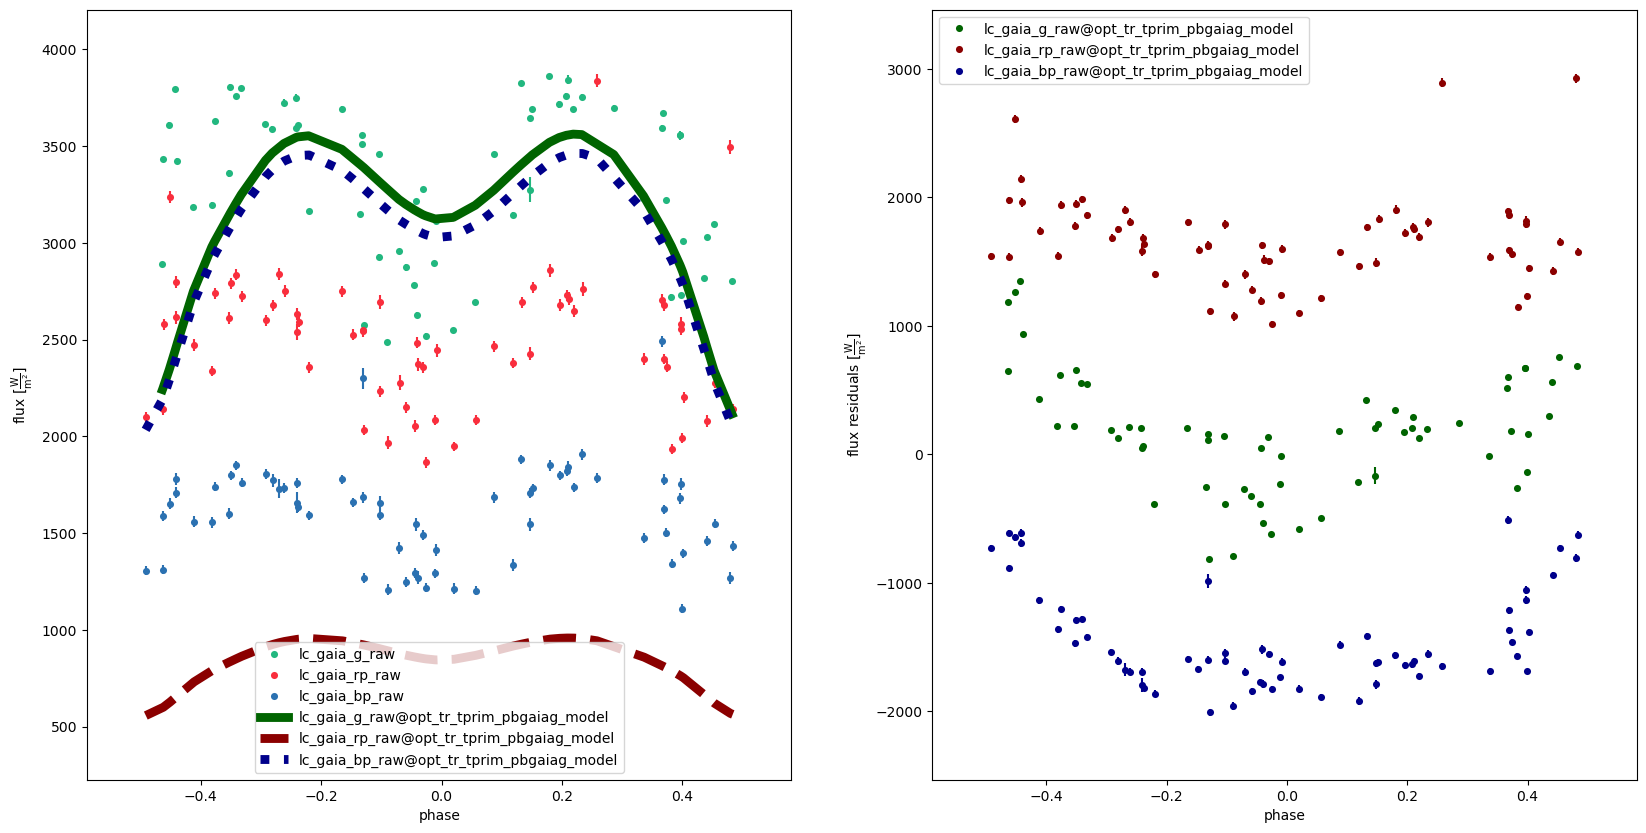

In [11]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/results/opt_tr_tprim_pbgaiag_solution', plot=False, reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)
gen_utils.abilitateDatasets(b, b.datasets)

In [12]:
print(solutionName)
print("-----------------------------------")
print(b[solutionName])

opt_tr_tprim_pbgaiag_solution
-----------------------------------
ParameterSet: 11 parameters
R  fitted_twigs@opt_tr_tprim_p...: ['teffratio@binary@orbit@component' 'teff@primary@star@component'
 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_parameters@opt_tr_tpr...: ['teffratio@binary@orbit@component', 'teff@primary@star@component', 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_distributions@opt_tr_...: False
   adopt_values@opt_tr_tprim_p...: True
R  message@opt_tr_tprim_pbgaia...: Maximum number of iterations has been exceeded.
R  niter@opt_tr_tprim_pbgaiag@...: 200
R  success@opt_tr_tprim_pbgaia...: False
R  initial_values@opt_tr_tprim...: [0.8800597213958596 6000.0 12.566370614359172]
R  fitted_values@opt_tr_tprim_...: [3.6374012789774905 3946.716379427977 445.6315403753456]
R  fitted_units@opt_tr_tprim_p...: ['' 'K' 'W']
   comments@opt_tr_tprim_pbgai...: 


In [30]:
# continuing above gaia pblum optimization, since it did not converge
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@lc_gaia_g_raw@primary'], label='tr_tprim_pbgaiag_cont', export=True,
						  subfolder='differential-norm-estimates', datasets=rawGaiaDatasets, maxiter=500)

External Solver: ./external-jobs/differential-norm-estimates/optimizer.nelder_mead_opt_tr_tprim_pbgaiag_cont.py ./results/opt_tr_tprim_pbgaiag_cont_solution


('opt_tr_tprim_pbgaiag_cont', 'opt_tr_tprim_pbgaiag_cont_solution')

Adopted:
teffratio@binary@orbit@component = 0.95702 
teff@primary@star@component = 4070.47247 K
pblum@primary@lc_gaia_g_raw@lc@dataset = 25445.02806 W

Original values:
  teffratio@binary@orbit@component 0.8800597213958596
  teff@primary@star@component 6000.0 K
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


Sat, 30 Sep 2023 21:36 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [03:00<00:00,  7.82it/s]


ParameterSet: 11 parameters
R  fitted_twigs@opt_tr_tprim_p...: ['teffratio@binary@orbit@component' 'teff@primary@star@component'
 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_parameters@opt_tr_tpr...: ['teffratio@binary@orbit@component', 'teff@primary@star@component', 'pblum@primary@lc_gaia_g_raw@lc@dataset']
   adopt_distributions@opt_tr_...: False
   adopt_values@opt_tr_tprim_p...: True
R  message@opt_tr_tprim_pbgaia...: Maximum number of iterations has been exceeded.
R  niter@opt_tr_tprim_pbgaiag_...: 500
R  success@opt_tr_tprim_pbgaia...: False
R  initial_values@opt_tr_tprim...: [0.8800597213958596 6000.0 12.566370614359172]
R  fitted_values@opt_tr_tprim_...: [0.9570218776515114 4070.472467436457 25445.028059731216]
R  fitted_units@opt_tr_tprim_p...: ['' 'K' 'W']
   comments@opt_tr_tprim_pbgai...: 
--------------------------------


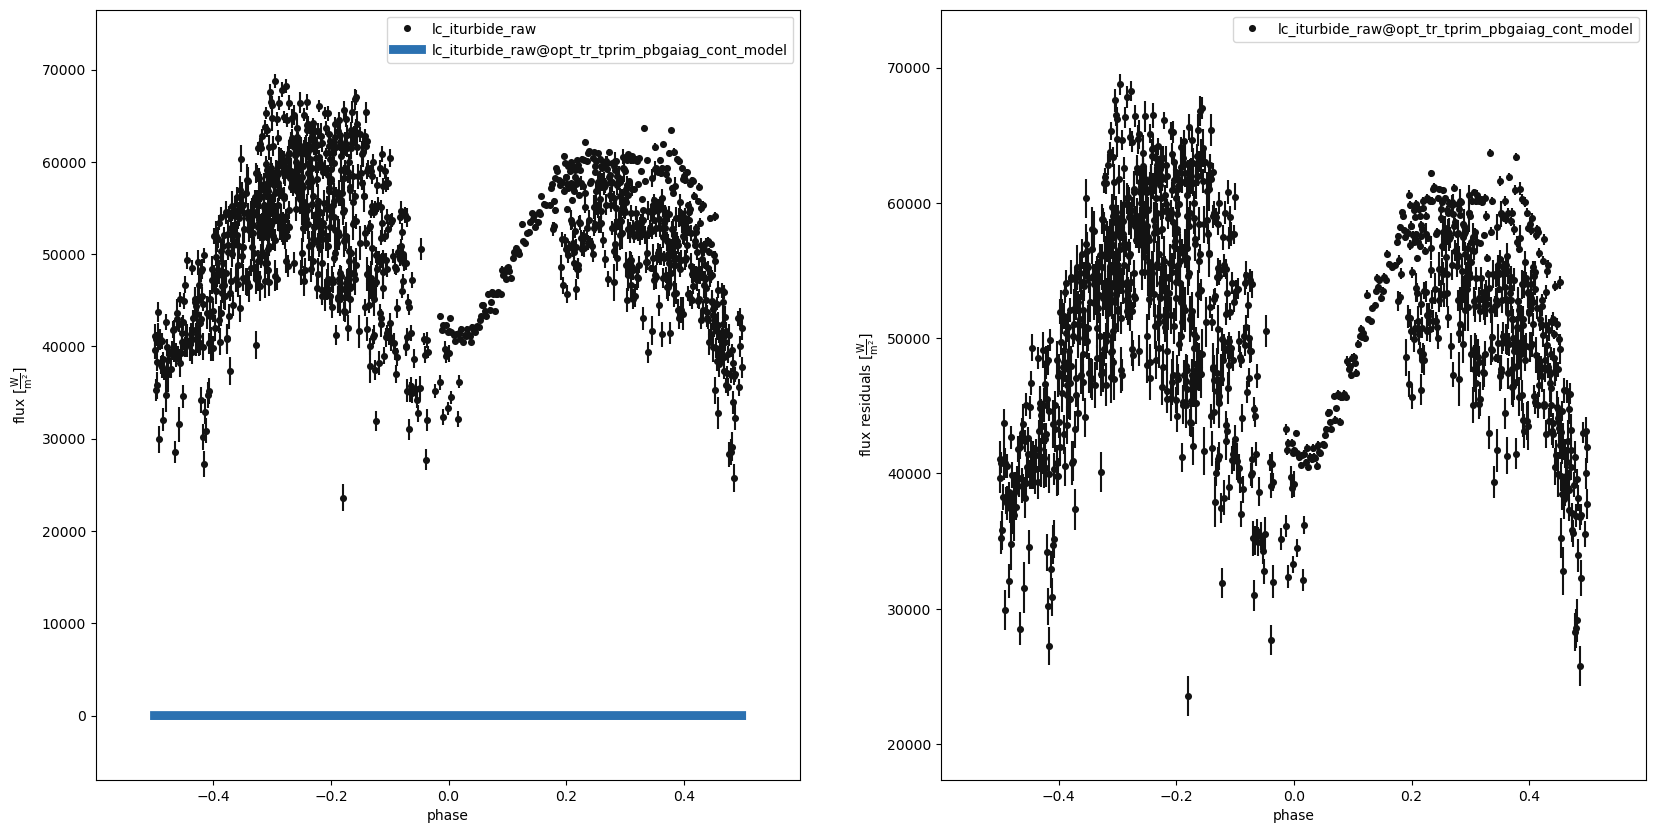

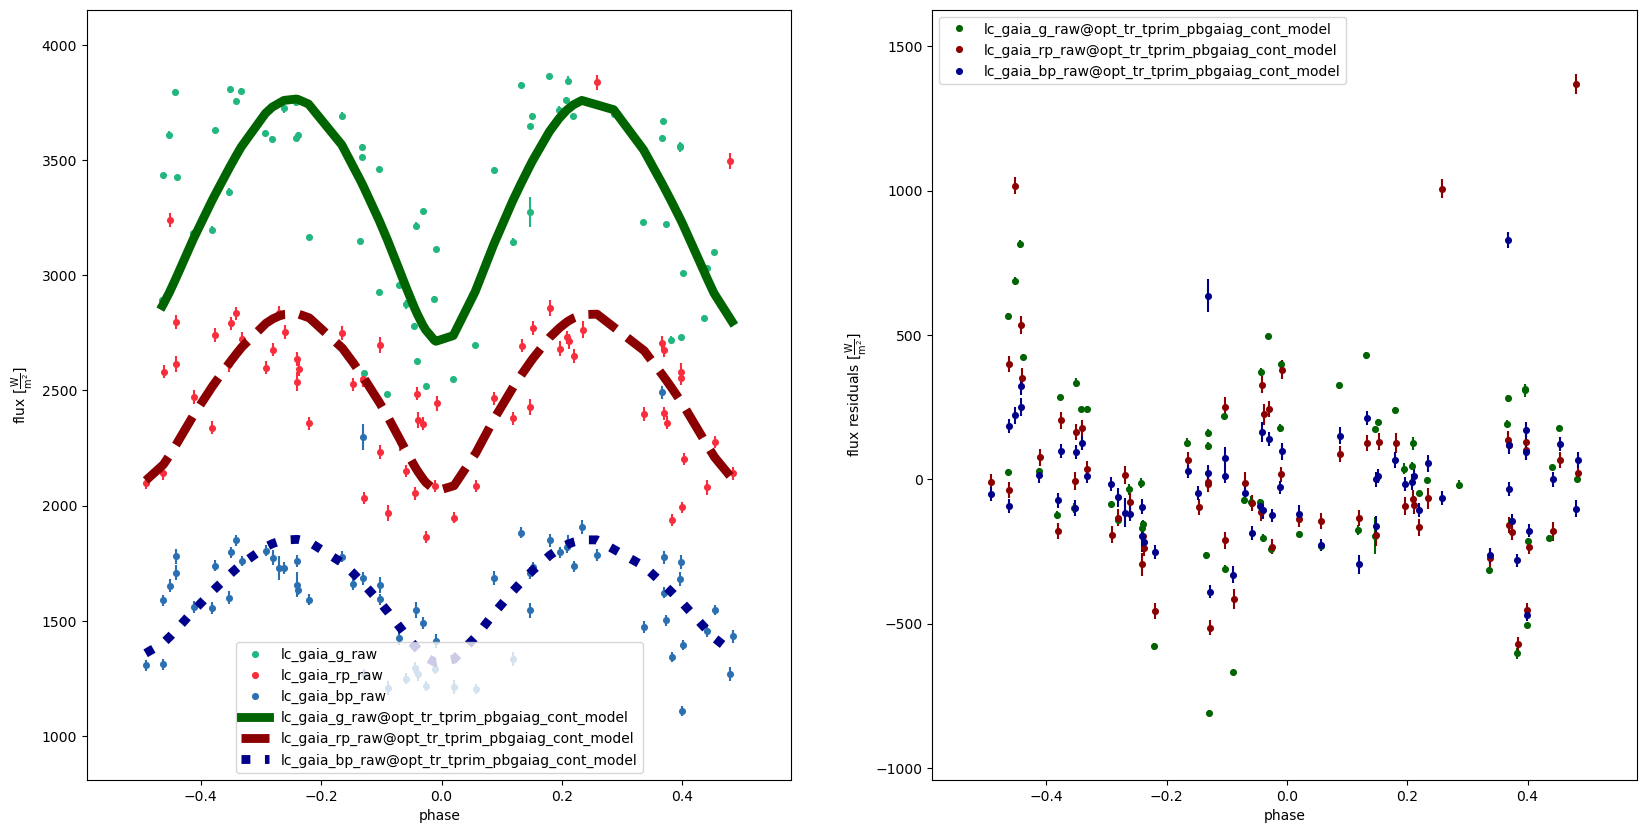

In [13]:
b.set_value_all(qualifier='enabled', value=True)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/results/opt_tr_tprim_pbgaiag_cont_solution', plot=False, reset_params=False)
print(b[solutionName])
print('--------------------------------')
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=['lc_iturbide_raw', rawGaiaDatasets], model=computeModelName, color=gen_utils.GAIA_RAW_PLOT_COLORS, legend=True)

### Iturbide `pblum` results

Adopted:
pblum@primary@lc_iturbide_raw@lc@dataset = 465264.61351 W

Original values:
  pblum@primary@lc_iturbide_raw@lc@dataset 465264.61351050576 W


Sat, 30 Sep 2023 21:40 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1414/1414 [02:59<00:00,  7.88it/s]


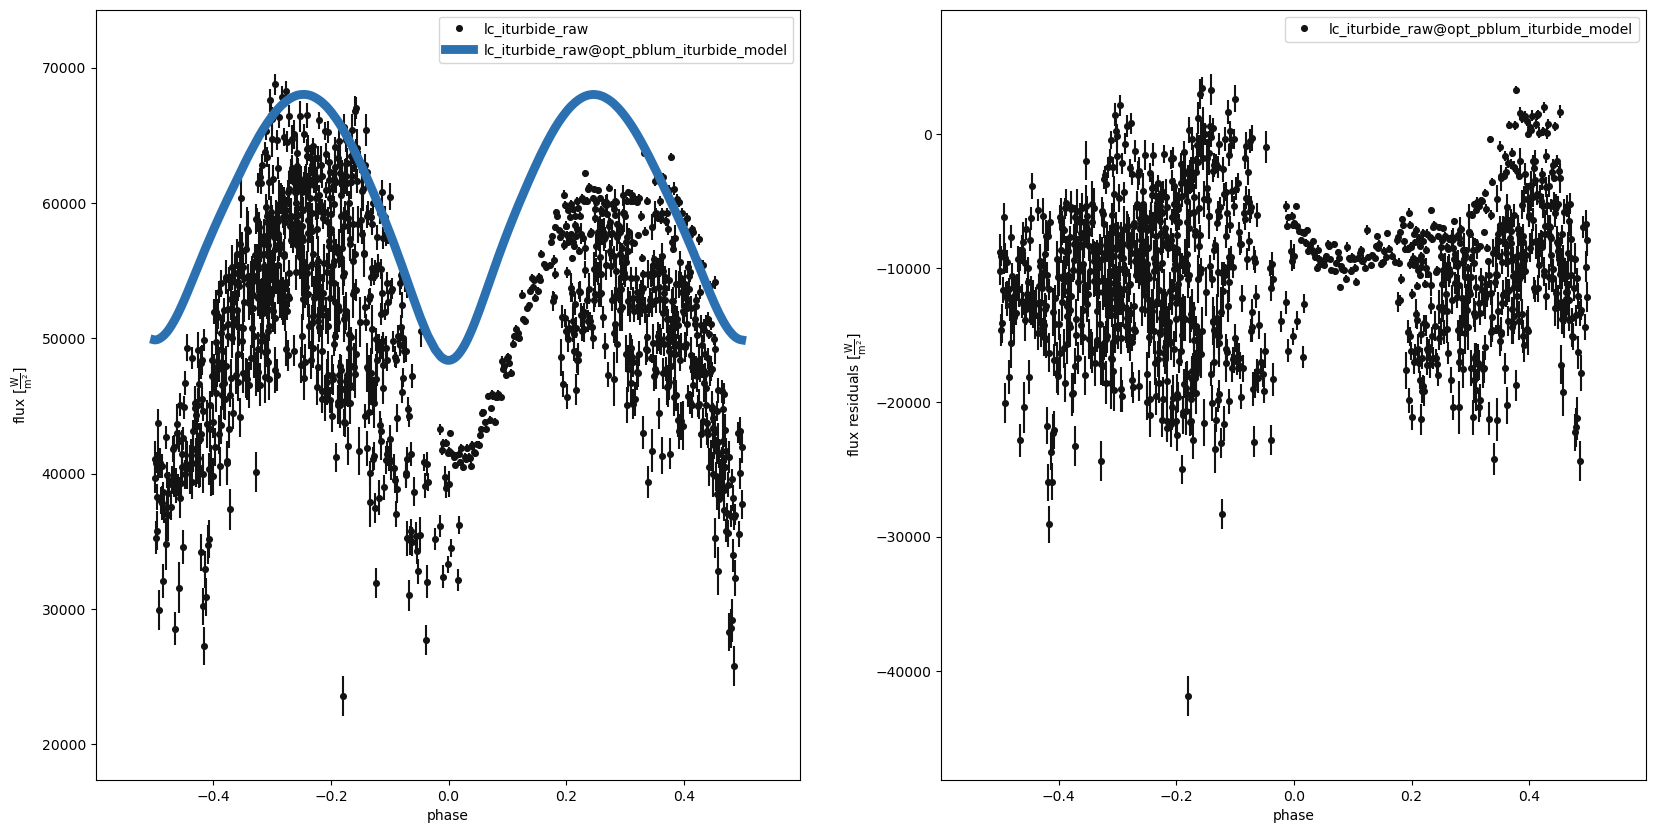

In [15]:
# need to re-optimize for the iturbide passband luminosity, using the teffratio obtained from gaia LCs
gen_utils.abilitateDatasets(b, ['lc_iturbide_raw'])
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/differential-norm-estimates/results/opt_pblum_iturbide_solution', plot=False, reset_params=False)
gen_utils.plotModelResidualsFigsize(b, (20,10), ['lc_iturbide_raw'], model=computeModelName, legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS)